The cell below removes the annoying app bar thing at the bottom of a notebook.

In [1]:
%%javascript
$('.nbp-app-bar').toggle()

<IPython.core.display.Javascript object>

In [301]:
import numpy as np
import pandas as pd
#import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import sqlite3
import seaborn as sns
#import pysal as ps
#from pysal.contrib.viz import mapping as maps
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler, StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, auc, roc_curve, classification_report, f1_score, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils import resample
import tensorflow as tf


%matplotlib inline

**These are the imports for AWS**

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, auc, roc_curve, f1_score

The cell below makes it so pandas will show me all the columns.

In [3]:
pd.set_option('display.max_columns', 40)

The below code for importing all the sql data came from: https://www.dataquest.io/blog/python-pandas-databases/

In [26]:
conn = sqlite3.connect("./OLD_FPA_FOD_20170508.sqlite")

In [88]:
df_all = pd.read_sql_query("SELECT * FROM fires;", conn)
#this grabs the whole db and puts it into a df using the sqlite3.Connection

In [28]:
df_all.shape

(1880465, 39)

In [29]:
df_all.head(2)

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,1,PNF-47,BJ8K,FOUNTAIN,None,None,None,None,None,2005,2453403.5,33,1300,9.0,Miscellaneous,2453403.5,33.0,1730,0.10,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,13,13,AAC0,PIGEON,None,None,None,None,None,2004,2453137.5,133,0845,1.0,Lightning,2453137.5,133.0,1530,0.25,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...


Since pandas can't handle the geometry information the Shape column is useless anyway, I'm going to drop it. It lives on in the original sqlite db.

In [89]:
df_all.drop(['Shape'], axis=1, inplace=True)

In [75]:
df_all.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME'],
      dtype='object')

In [76]:
df_all.STAT_CAUSE_DESCR.unique()

array(['Miscellaneous', 'Lightning', 'Debris Burning', 'Campfire',
       'Equipment Use', 'Arson', 'Children', 'Railroad', 'Smoking',
       'Powerline', 'Structure', 'Fireworks', 'Missing/Undefined'],
      dtype=object)

There are entries in my target column that I can't use so I am dropping them.

In [90]:
df_all.drop(df_all[df_all['STAT_CAUSE_DESCR'] == 'Missing/Undefined'].index, inplace=True)

In [78]:
df_all.shape

(1713742, 38)

In [79]:
df_all.dtypes

OBJECTID                        int64
FOD_ID                          int64
FPA_ID                         object
SOURCE_SYSTEM_TYPE             object
SOURCE_SYSTEM                  object
NWCG_REPORTING_AGENCY          object
NWCG_REPORTING_UNIT_ID         object
NWCG_REPORTING_UNIT_NAME       object
SOURCE_REPORTING_UNIT          object
SOURCE_REPORTING_UNIT_NAME     object
LOCAL_FIRE_REPORT_ID           object
LOCAL_INCIDENT_ID              object
FIRE_CODE                      object
FIRE_NAME                      object
ICS_209_INCIDENT_NUMBER        object
ICS_209_NAME                   object
MTBS_ID                        object
MTBS_FIRE_NAME                 object
COMPLEX_NAME                   object
FIRE_YEAR                       int64
DISCOVERY_DATE                float64
DISCOVERY_DOY                   int64
DISCOVERY_TIME                 object
STAT_CAUSE_CODE               float64
STAT_CAUSE_DESCR               object
CONT_DATE                     float64
CONT_DOY    

In [80]:
df_all.isnull().sum()

OBJECTID                            0
FOD_ID                              0
FPA_ID                              0
SOURCE_SYSTEM_TYPE                  0
SOURCE_SYSTEM                       0
NWCG_REPORTING_AGENCY               0
NWCG_REPORTING_UNIT_ID              0
NWCG_REPORTING_UNIT_NAME            0
SOURCE_REPORTING_UNIT               0
SOURCE_REPORTING_UNIT_NAME          0
LOCAL_FIRE_REPORT_ID          1297372
LOCAL_INCIDENT_ID              705847
FIRE_CODE                     1396084
FIRE_NAME                      839288
ICS_209_INCIDENT_NUMBER       1691038
ICS_209_NAME                  1691038
MTBS_ID                       1703584
MTBS_FIRE_NAME                1703584
COMPLEX_NAME                  1708655
FIRE_YEAR                           0
DISCOVERY_DATE                      0
DISCOVERY_DOY                       0
DISCOVERY_TIME                 770477
STAT_CAUSE_CODE                     0
STAT_CAUSE_DESCR                    0
CONT_DATE                      796359
CONT_DOY    

I'm going to create a new df, df_pred, by dropping columns from the FPA_FOD data. I'm going to read that into a csv so I have it for later, and then stop using the full set. I will keep the full set on my SSD, of course. I am making these decisions based on the data atlas located here: https://www.kaggle.com/davideanastasia/contour-map-of-us-wildfire-dataset/data

In [81]:
df_all['FIRE_CODE'].value_counts()

D44Z    9451
5555    5144
D5GJ    3459
0001    3329
0000    1928
2300    1892
EKV3    1032
4700    1003
EKW0     938
0100     904
EKT5     883
5900     833
EKV0     756
EK2R     729
7000     721
EKV5     703
EK2D     690
EK3D     666
EK2N     660
EKV6     647
EK2A     624
EKT4     614
EK2B     585
EK2Q     551
7500     537
EN0A     533
EK2F     513
EKW2     504
EKS5     495
EKT1     493
        ... 
A7MY       1
E5H0       1
H8T7       1
FAX1       1
JQ9H       1
E4FS       1
D0QM       1
FX37       1
G50T       1
EEW0       1
GL83       1
BG5A       1
JXV0       1
A3JE       1
C8P1       1
FD4V       1
CCP6       1
A3R7       1
HUW1       1
HW1C       1
J4GE       1
BRU3       1
EE4F       1
HVN4       1
JV9N       1
G6MH       1
CF2J       1
HDM4       1
ECM1       1
J3RY       1
Name: FIRE_CODE, Length: 166669, dtype: int64

I'm going to drop features that I don't care about and then do feature engineering.

In [91]:
df_all = df_all.drop(['OBJECTID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
                  'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
                  'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
                  'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
                  'LOCAL_INCIDENT_ID', 'FIRE_NAME',
                  'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
                  'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_TIME', 
                  'STAT_CAUSE_CODE', 'CONT_TIME', 
                  'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_CODE', 
                  'OWNER_DESCR', 'COUNTY', 'FIPS_NAME'], axis=1)

#at some point redo this. Instead of doing a drop just include all feats I want to keep. Much more readable, shorter

In [83]:
df_all.shape

(1713742, 10)

In [84]:
df_all.head(20)

,FOD_ID,FIRE_CODE,DISCOVERY_DATE,DISCOVERY_DOY,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,FIRE_SIZE,STATE,FIPS_CODE
0,1,BJ8K,2453403.5,33,Miscellaneous,2453403.5,33.0,0.10,CA,063
1,2,AAC0,2453137.5,133,Lightning,2453137.5,133.0,0.25,CA,061
2,3,A32W,2453156.5,152,Debris Burning,2453156.5,152.0,0.10,CA,017
3,4,None,2453184.5,180,Lightning,2453189.5,185.0,0.10,CA,003
4,5,None,2453184.5,180,Lightning,2453189.5,185.0,0.10,CA,003
5,6,None,2453186.5,182,Lightning,2453187.5,183.0,0.10,CA,005
6,7,None,2453187.5,183,Lightning,2453188.5,184.0,0.10,CA,017
7,8,BK5X,2453437.5,67,Debris Burning,2453437.5,67.0,0.80,CA,None
8,9,BLPQ,2453444.5,74,Debris Burning,2453444.5,74.0,1.00,CA,None
9,10,None,2453187.5,183,Lightning,2453188.5,184.0,0.10,CA,005


Time for feature engineering.

The 2 columns with the dates for discovery and containment are in the Julian format so I will have to convert them into gregorian timestamps and then engineer a duration. I do think day of year discovered will have some predictive power and will keep that column. I will also engineer month and a day-of-week discovered features.

In [92]:
df_all['START_DATE'] = pd.to_datetime(df_all['DISCOVERY_DATE'], unit='D', infer_datetime_format=True, origin='julian')

In [93]:
df_all['END_DATE'] = pd.to_datetime(df_all['CONT_DATE'], unit='D', infer_datetime_format=True, origin='julian')

In [87]:
df_all.head(2)

,FOD_ID,FIRE_CODE,DISCOVERY_DATE,DISCOVERY_DOY,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,FIRE_SIZE,STATE,FIPS_CODE,START_DATE,END_DATE
0,1,BJ8K,2453403.5,33,Miscellaneous,2453403.5,33.0,0.10,CA,063,2005-02-02,2005-02-02
1,2,AAC0,2453137.5,133,Lightning,2453137.5,133.0,0.25,CA,061,2004-05-12,2004-05-12


In [94]:
df_all = df_all.drop(['DISCOVERY_DATE', 'CONT_DATE'], axis=1)

In [89]:
df_all.head(3)

,FOD_ID,FIRE_CODE,DISCOVERY_DOY,STAT_CAUSE_DESCR,CONT_DOY,FIRE_SIZE,STATE,FIPS_CODE,START_DATE,END_DATE
0,1,BJ8K,33,Miscellaneous,33.0,0.10,CA,063,2005-02-02,2005-02-02
1,2,AAC0,133,Lightning,133.0,0.25,CA,061,2004-05-12,2004-05-12
2,3,A32W,152,Debris Burning,152.0,0.10,CA,017,2004-05-31,2004-05-31


In [95]:
df_all['BURN_TIME'] = (df_all['END_DATE'] - df_all['START_DATE']).astype('timedelta64[D]')

In [96]:
df_all['MONTH'] = pd.DatetimeIndex(df_all['START_DATE']).month

In [97]:
df_all['DOW'] = pd.DatetimeIndex(df_all['START_DATE']).weekday_name

In [93]:
df_all.head(3)

,FOD_ID,FIRE_CODE,DISCOVERY_DOY,STAT_CAUSE_DESCR,CONT_DOY,FIRE_SIZE,STATE,FIPS_CODE,START_DATE,END_DATE,BURN_TIME,MONTH,DOW
0,1,BJ8K,33,Miscellaneous,33.0,0.10,CA,063,2005-02-02,2005-02-02,0.0,2,Wednesday
1,2,AAC0,133,Lightning,133.0,0.25,CA,061,2004-05-12,2004-05-12,0.0,5,Wednesday
2,3,A32W,152,Debris Burning,152.0,0.10,CA,017,2004-05-31,2004-05-31,0.0,5,Monday


In [98]:
df_all = df_all.drop(['CONT_DOY'], axis=1)

In [99]:
df_all = df_all.drop(['END_DATE'], axis=1)

In [96]:
df_all.head(3)

,FOD_ID,FIRE_CODE,DISCOVERY_DOY,STAT_CAUSE_DESCR,FIRE_SIZE,STATE,FIPS_CODE,START_DATE,BURN_TIME,MONTH,DOW
0,1,BJ8K,33,Miscellaneous,0.10,CA,063,2005-02-02,0.0,2,Wednesday
1,2,AAC0,133,Lightning,0.25,CA,061,2004-05-12,0.0,5,Wednesday
2,3,A32W,152,Debris Burning,0.10,CA,017,2004-05-31,0.0,5,Monday


In [100]:
df_all = df_all.drop(['FOD_ID'], axis=1)

In [98]:
df_all.head()

,FIRE_CODE,DISCOVERY_DOY,STAT_CAUSE_DESCR,FIRE_SIZE,STATE,FIPS_CODE,START_DATE,BURN_TIME,MONTH,DOW
0,BJ8K,33,Miscellaneous,0.10,CA,063,2005-02-02,0.0,2,Wednesday
1,AAC0,133,Lightning,0.25,CA,061,2004-05-12,0.0,5,Wednesday
2,A32W,152,Debris Burning,0.10,CA,017,2004-05-31,0.0,5,Monday
3,None,180,Lightning,0.10,CA,003,2004-06-28,5.0,6,Monday
4,None,180,Lightning,0.10,CA,003,2004-06-28,5.0,6,Monday


In [99]:
df_all['BURN_TIME'].isnull().sum()

796359

In [48]:
np.max(df_all['BURN_TIME'])

4018.0

The above fire is claiming to have burned for 11 years. No forest fire has ever burnt that long. So there are fires in the data with burn times much longer than any forest fire has burned, bad data. I need to take them out. I researched the biggest fires in North America. The largest was in  Canada in 1950: https://en.wikipedia.org/wiki/Chinchaga_Fire
It burned for 153 days. This is a longer time than the true burn of any fire in my data set but I want to be conservative in dropping data so I will use 153 days as a cut-off.

In [102]:
(df_all.loc[df_all['BURN_TIME'] > 153])

,FIRE_CODE,DISCOVERY_DOY,STAT_CAUSE_DESCR,FIRE_SIZE,STATE,FIPS_CODE,START_DATE,BURN_TIME,MONTH,DOW
17579,C0DY,190,Lightning,2097.00,CA,107,2006-07-09,155.0,7,Sunday
17587,C0DY,190,Lightning,4654.00,CA,107,2006-07-09,155.0,7,Sunday
18301,DH3H,1,Arson,5.60,UT,011,2007-01-01,161.0,1,Monday
25280,DVD0,217,Lightning,11791.00,WA,007,2007-08-05,155.0,8,Sunday
27799,EA9F,174,Lightning,13116.00,CA,093,2008-06-22,177.0,6,Sunday
29304,EA9F,189,Lightning,1779.00,CA,093,2008-07-07,162.0,7,Monday
31081,D36S,71,Miscellaneous,0.10,CO,019,2008-03-11,184.0,3,Tuesday
34763,D0AL,118,Lightning,0.30,VA,015,2008-04-27,365.0,4,Sunday
39145,EQ4C,18,Arson,113.00,AR,101,2009-01-18,213.0,1,Sunday
48658,None,301,Lightning,0.10,CA,None,1992-10-27,365.0,10,Tuesday


642 rows! Dropped.


In [103]:
df_all = df_all.drop(df_all[df_all.BURN_TIME > 153].index)

In [104]:
df_all.shape

(1713100, 10)

I'm going to make a new column to use as my target, "Arson". If the cause was arson the value will be 1, else 0.

In [105]:
df_all.loc[df_all['STAT_CAUSE_DESCR'] != 'Arson', 'ARSON'] = 0
df_all.loc[df_all['STAT_CAUSE_DESCR'] == 'Arson', 'ARSON'] = 1

df_all.head(3)

,FIRE_CODE,DISCOVERY_DOY,STAT_CAUSE_DESCR,FIRE_SIZE,STATE,FIPS_CODE,START_DATE,BURN_TIME,MONTH,DOW,ARSON
0,BJ8K,33,Miscellaneous,0.10,CA,063,2005-02-02,0.0,2,Wednesday,0.0
1,AAC0,133,Lightning,0.25,CA,061,2004-05-12,0.0,5,Wednesday,0.0
2,A32W,152,Debris Burning,0.10,CA,017,2004-05-31,0.0,5,Monday,0.0


Wow that was a lot faster.

In [106]:
df_all['ARSON'] = df_all['ARSON'].astype(int)

Now That I've made the target column for arson I can drop the original column.

In [107]:
df_all.shape

(1713100, 11)

In [47]:
df_all.head()

,FIRE_CODE,DISCOVERY_DOY,STAT_CAUSE_DESCR,FIRE_SIZE,STATE,FIPS_CODE,START_DATE,BURN_TIME,MONTH,DOW,ARSON
0,BJ8K,33,Miscellaneous,0.10,CA,063,2005-02-02,0.0,2,Wednesday,0
1,AAC0,133,Lightning,0.25,CA,061,2004-05-12,0.0,5,Wednesday,0
2,A32W,152,Debris Burning,0.10,CA,017,2004-05-31,0.0,5,Monday,0
3,None,180,Lightning,0.10,CA,003,2004-06-28,5.0,6,Monday,0
4,None,180,Lightning,0.10,CA,003,2004-06-28,5.0,6,Monday,0


Over half of all the FIRE_CODE entries are nulls. DROPPED.

In [107]:
df_all.drop(['FIRE_CODE'], axis=1, inplace=True)

In [47]:
df_all.isnull().sum()

DISCOVERY_DOY            0
STAT_CAUSE_DESCR         0
FIRE_SIZE                0
STATE                    0
FIPS_CODE           636254
START_DATE               0
BURN_TIME           796359
MONTH                    0
DOW                      0
ARSON                    0
dtype: int64

I'm going to drop FIPS, because I think State will cover location and going all the way down to county risks overfitting on historic data. A county may have an arsonist in it for a time who may have been arrested, moved or died; using a coefficient for that county that was affected while the arsonist was acitive will decrease accuracy. This is also true in a state but given the differences in population between states and differenes in weather conditions I think it will be predictive and have a lower risk of over fitting.

In [108]:
df_all.drop(['FIPS_CODE'], axis=1, inplace=True)

After much consideration I am going to drop the start date, keep the day-of-year, but transform it to be cyclic so the algorithms can see that 1 and 365 are actually closer than 60 and 365.

In [109]:
df_all.drop(['START_DATE'], axis=1, inplace=True)

I don't really need to do this because I'm going to label encode and then one-hot encode it later but I want to do some visualization.

In [110]:
df_all['MONTH'] = df_all['MONTH'].apply(lambda x: calendar.month_name[x])

In this notebook I'm going to just drop the missing burn time values and then include it in my analysis. See what that gets me.

In [111]:
df_all.drop(df_all[df_all['BURN_TIME'].isnull() == True].index, inplace=True)

In [55]:
df_all.head(2)

,DISCOVERY_DOY,STAT_CAUSE_DESCR,FIRE_SIZE,STATE,BURN_TIME,MONTH,DOW,ARSON
0,33,Miscellaneous,0.10,CA,0.0,February,Wednesday,0
1,133,Lightning,0.25,CA,0.0,May,Wednesday,0


In [112]:
df_graph = df_all

In [113]:
df_graph.head(2)

,DISCOVERY_DOY,STAT_CAUSE_DESCR,FIRE_SIZE,STATE,BURN_TIME,MONTH,DOW,ARSON
0,33,Miscellaneous,0.10,CA,0.0,February,Wednesday,0
1,133,Lightning,0.25,CA,0.0,May,Wednesday,0


In [114]:
df_graph.to_csv('./graph_df')

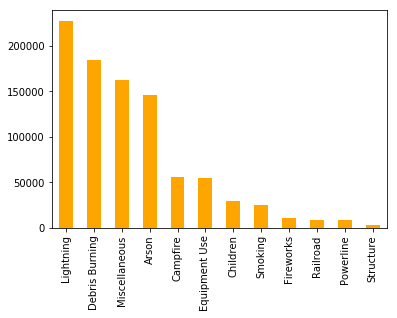

In [125]:
df_graph['STAT_CAUSE_DESCR'].value_counts().plot(kind='bar',color='orange');

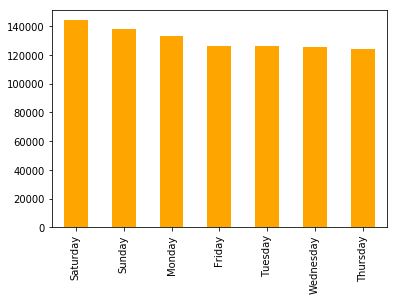

In [116]:
df_graph['DOW'].value_counts().plot(kind='bar',color='orange');

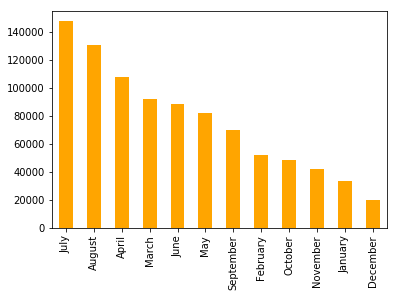

In [126]:
df_graph['MONTH'].value_counts().plot(kind='bar',color='orange');

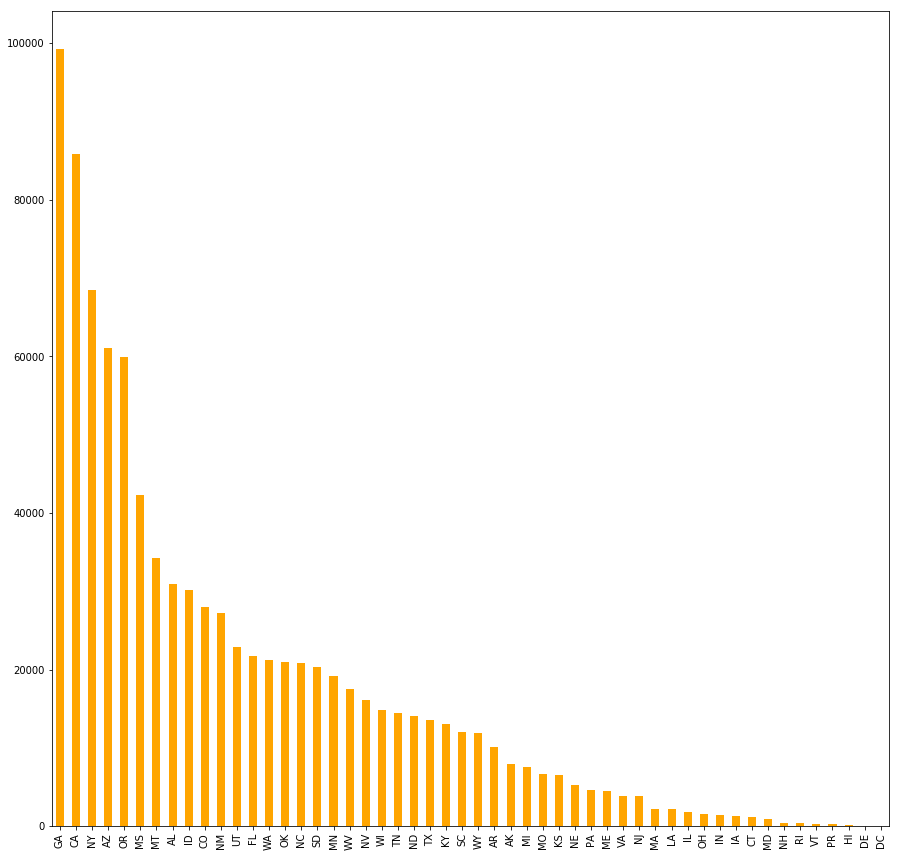

In [132]:
fig, ax = plt.subplots(figsize=(15,15))
df_graph['STATE'].value_counts().head(n=52).plot(kind='bar',color='orange');

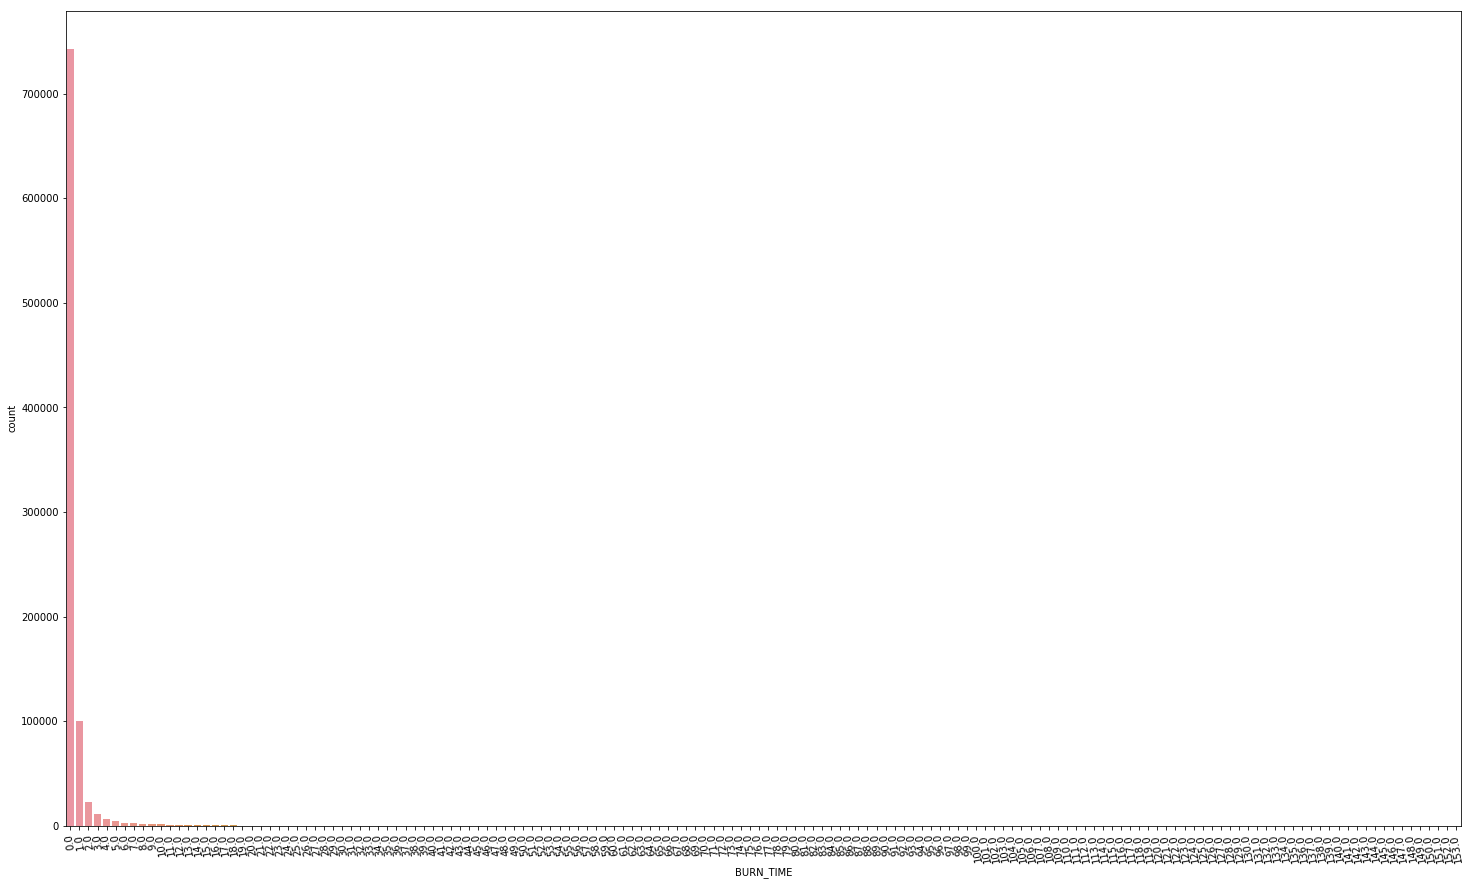

In [133]:
fig, ax = plt.subplots(figsize=(25,15))
plt.xticks(rotation = 100)
sns.countplot(x=df_graph['BURN_TIME'], data=df_graph);

We tend to think of forest fires as giant conflagurations but the vast majority are suppressed within a week.

In [59]:
df_all.drop(['STAT_CAUSE_DESCR'], axis=1, inplace=True)

In [60]:
df_all.ARSON.value_counts()

0    770565
1    146176
Name: ARSON, dtype: int64

In [61]:
281455/1713742

0.164234172938517

16.42% of these fires were started by arsonists! Crazy. Also: that's a pretty unbalanced class. Hopefully that won't cause problems. Famous last words.

In [62]:
df_all.dtypes

DISCOVERY_DOY      int64
FIRE_SIZE        float64
STATE             object
BURN_TIME        float64
MONTH             object
DOW               object
ARSON              int64
dtype: object

In [63]:
df_all.head(2)

,DISCOVERY_DOY,FIRE_SIZE,STATE,BURN_TIME,MONTH,DOW,ARSON
0,33,0.10,CA,0.0,February,Wednesday,0
1,133,0.25,CA,0.0,May,Wednesday,0


I need to encode my categorical values. I can use one-hot encoding or get dummies and drop one column. For month and day-of-week there are only 12 and 7 categories, respectively, so for them I'll get dummies. For the other 2 I'll use one-hot because there are so categories and I don't want to dataframe that big considering how much modeling I'm doing, the ram required would get too big.

In [64]:
df_wburn = df_all

In [65]:
df_wburn.shape

(916741, 7)

In [66]:
df_wburn.STATE.nunique()

52

In [67]:
df_wburn.head(20)

,DISCOVERY_DOY,FIRE_SIZE,STATE,BURN_TIME,MONTH,DOW,ARSON
0,33,0.10,CA,0.0,February,Wednesday,0
1,133,0.25,CA,0.0,May,Wednesday,0
2,152,0.10,CA,0.0,May,Monday,0
3,180,0.10,CA,5.0,June,Monday,0
4,180,0.10,CA,5.0,June,Monday,0
5,182,0.10,CA,1.0,June,Wednesday,0
6,183,0.10,CA,1.0,July,Thursday,0
7,67,0.80,CA,0.0,March,Tuesday,0
8,74,1.00,CA,0.0,March,Tuesday,0
9,183,0.10,CA,1.0,July,Thursday,0


In [68]:
df_wburn.isnull().sum()

DISCOVERY_DOY    0
FIRE_SIZE        0
STATE            0
BURN_TIME        0
MONTH            0
DOW              0
ARSON            0
dtype: int64

In [69]:
df_wburn.dtypes

DISCOVERY_DOY      int64
FIRE_SIZE        float64
STATE             object
BURN_TIME        float64
MONTH             object
DOW               object
ARSON              int64
dtype: object

I want to make the DISCOVERED_DOY cyclic.

In [70]:
df_wburn.shape

(916741, 7)

The idea here is to numerically represent the value of the day of the year a fire starts on, while including the cyclic nature of years in that value. I treat the year as a circle with a circumference of 365 (the days in a year). I treat the day of the year as a radius extending from the center of the circle out to it's edge. I multiply this by 2 to make it the diameter and then multiply that by pi. That gives me the circumference of a different circle with a diameter of 2 times the day of the year, so I divide that circumference by 365, the circumference of the full year. Now I need to scale this number in a way that reflects its cyclic nature. Sine and cosine both do this, and both are equally valid, so I include both. Collinearity would be a worry but as I intend to perform a PCA decomposition and dimensionality reduction on all of my features before passing them to the model there is no problem. After creating these 2 new features I will drop DISCOVER_DOY as by itself it is useless for modeling.

In [71]:
df_wburn['DOY_SIN'] = np.sin(df_wburn.DISCOVERY_DOY*(2.*np.pi/365))
df_wburn['DOY_COS'] = np.cos(df_wburn.DISCOVERY_DOY*(2.*np.pi/365))

In [72]:
df_wburn.shape

(916741, 9)

In [73]:
df_wburn.head(2)

,DISCOVERY_DOY,FIRE_SIZE,STATE,BURN_TIME,MONTH,DOW,ARSON,DOY_SIN,DOY_COS
0,33,0.10,CA,0.0,February,Wednesday,0,0.538005,0.842942
1,133,0.25,CA,0.0,May,Wednesday,0,0.752667,-0.658402


In [74]:
df_wburn = df_wburn.drop(['DISCOVERY_DOY'], axis=1)

In [75]:
df_wburn.shape

(916741, 8)

In [76]:
df_wburn.head(2)

,FIRE_SIZE,STATE,BURN_TIME,MONTH,DOW,ARSON,DOY_SIN,DOY_COS
0,0.10,CA,0.0,February,Wednesday,0,0.538005,0.842942
1,0.25,CA,0.0,May,Wednesday,0,0.752667,-0.658402


Need to scale my numeric columns.

In [77]:
ss = StandardScaler()

In [78]:
df_wburn['BURN_TIME'] = ss.fit_transform(df_wburn['BURN_TIME'].values.reshape(-1, 1))

In [79]:
df_wburn.shape

(916741, 8)

In [80]:
df_wburn.head(3)

,FIRE_SIZE,STATE,BURN_TIME,MONTH,DOW,ARSON,DOY_SIN,DOY_COS
0,0.10,CA,-0.1584,February,Wednesday,0,0.538005,0.842942
1,0.25,CA,-0.1584,May,Wednesday,0,0.752667,-0.658402
2,0.10,CA,-0.1584,May,Monday,0,0.501242,-0.865307


In [15]:
df_wburn.shape

(916741, 77)

In [138]:
robsca = RobustScaler()

In [139]:
df_wburn['FIRE_SIZE'] = robsca.fit_transform(df_wburn['FIRE_SIZE'].values.reshape(-1, 1))

In [140]:
df_wburn.head(30)

,STAT_CAUSE_DESCR,FIRE_SIZE,STATE,BURN_TIME,MONTH,DOW,ARSON,DOY_SIN,DOY_COS
0,Miscellaneous,-0.142857,CA,-0.158400,February,Wednesday,0,0.538005,0.842942
1,Lightning,-0.089286,CA,-0.158400,May,Wednesday,0,0.752667,-0.658402
2,Debris Burning,-0.142857,CA,-0.158400,May,Monday,0,0.501242,-0.865307
3,Lightning,-0.142857,CA,0.577043,June,Monday,0,0.043022,-0.999074
4,Lightning,-0.142857,CA,0.577043,June,Monday,0,0.043022,-0.999074
5,Lightning,-0.142857,CA,-0.011312,June,Wednesday,0,0.008607,-0.999963
6,Lightning,-0.142857,CA,-0.011312,July,Thursday,0,-0.008607,-0.999963
7,Debris Burning,0.107143,CA,-0.158400,March,Tuesday,0,0.914128,0.405426
8,Debris Burning,0.178571,CA,-0.158400,March,Tuesday,0,0.956235,0.292600
9,Lightning,-0.142857,CA,-0.011312,July,Thursday,0,-0.008607,-0.999963


In [141]:
df_wburn.shape

(916741, 9)

**IF YOU DO NOT WRITE THE DATAFRAME TO A CSV AND THEN READ IT BACK IN TO A DATAFRAME THE ENCODING LOOP WILL DESTROY THE DATA. DO NOT ASK ME WHY, MY ONLY THEORY IS THAT WE LIVE IN A CHAOTIC, COLD, AND UNCARING UNIVERSE.**

In [142]:
df_wburn.to_csv('./data_to_encode.csv', index=False)

In [143]:
df_wburn = pd.read_csv('./data_to_encode.csv')
print(df_wburn.shape)

(916741, 9)


OKAY. Now everything that needed to be is scaled and normalized. Time to encode my categorical values.

In [142]:
lab_enc = LabelEncoder()
oh_enc = OneHotEncoder()

need_encoding = [df_wburn['STATE'], df_wburn['MONTH'], df_wburn['DOW']]

for feat in need_encoding:
    feat_int_encoded = lab_enc.fit_transform(feat)
    feat_int_encoded_reshape = feat_int_encoded.reshape(len(feat_int_encoded), 1) 
    feat_onehot_encoded = oh_enc.fit_transform(feat_int_encoded_reshape)
    df_feat = pd.DataFrame(feat_onehot_encoded.toarray())
    df_wburn2 = pd.merge(df_wburn, df_feat, left_index=True, right_index=True)
    df_wburn = df_wburn2

df_wburn.shape

(916741, 79)

In [143]:
df_wburn.head()

,FIRE_SIZE,STATE,BURN_TIME,MONTH,DOW,ARSON,DOY_SIN,DOY_COS,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,...,51,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,0,1,2,3,4,5,6
0,0.10,CA,-0.158400,February,Wednesday,0,0.538005,0.842942,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.25,CA,-0.158400,May,Wednesday,0,0.752667,-0.658402,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.10,CA,-0.158400,May,Monday,0,0.501242,-0.865307,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.10,CA,0.577043,June,Monday,0,0.043022,-0.999074,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.10,CA,0.577043,June,Monday,0,0.043022,-0.999074,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [144]:
df_wburn.columns

Index(['FIRE_SIZE',     'STATE', 'BURN_TIME',     'MONTH',       'DOW',
           'ARSON',   'DOY_SIN',   'DOY_COS',       '0_x',       '1_x',
             '2_x',       '3_x',       '4_x',       '5_x',       '6_x',
             '7_x',       '8_x',       '9_x',      '10_x',      '11_x',
                12,          13,          14,          15,          16,
                17,          18,          19,          20,          21,
                22,          23,          24,          25,          26,
                27,          28,          29,          30,          31,
                32,          33,          34,          35,          36,
                37,          38,          39,          40,          41,
                42,          43,          44,          45,          46,
                47,          48,          49,          50,          51,
             '0_y',       '1_y',       '2_y',       '3_y',       '4_y',
             '5_y',       '6_y',       '7_y',       '8_y',      

In [145]:
df_wburn.head(3)

,FIRE_SIZE,STATE,BURN_TIME,MONTH,DOW,ARSON,DOY_SIN,DOY_COS,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,...,51,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,0,1,2,3,4,5,6
0,0.10,CA,-0.1584,February,Wednesday,0,0.538005,0.842942,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.25,CA,-0.1584,May,Wednesday,0,0.752667,-0.658402,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.10,CA,-0.1584,May,Monday,0,0.501242,-0.865307,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [146]:
df_wburn.tail(3)

,FIRE_SIZE,STATE,BURN_TIME,MONTH,DOW,ARSON,DOY_SIN,DOY_COS,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,...,51,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,0,1,2,3,4,5,6
916738,1.0,CA,-0.011312,September,Wednesday,1,-0.999917,-0.012910,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
916739,4.0,CA,0.577043,August,Saturday,0,-0.501242,-0.865307,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
916740,0.5,CA,-0.158400,May,Thursday,0,0.559589,-0.828770,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [147]:
df_wburn.STATE.nunique()

52

In [148]:
df_wburn.DOW.nunique()

7

In [149]:
df_wburn.MONTH.nunique()

12

In [150]:
df_wburn.drop(['STATE', 'MONTH', 'DOW'], axis=1, inplace=True)

In [151]:
df_wburn.shape

(916741, 76)

In [152]:
df_wburn.isnull().sum().sum()

0

I wrote the dataframe to .csv as this is what I'm going to perform PCA on and I wanted it as a file.

In [153]:
df_wburn.to_csv('./final_df.csv', index=False)

In [154]:
df_wburn = pd.read_csv('./final_df.csv')

In [155]:
df_wburn.head(3)

,FIRE_SIZE,BURN_TIME,ARSON,DOY_SIN,DOY_COS,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12,13,14,...,51,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,0,1,2,3,4,5,6
0,0.10,-0.1584,0,0.538005,0.842942,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.25,-0.1584,0,0.752667,-0.658402,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.10,-0.1584,0,0.501242,-0.865307,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


That's a nice looking dataframe for machine learning. To deal with the all that dimensionality and collinearity I'm going to use PCA.

Futher down you can see there's a strange phenomenon where the first PCA feature after transformation accounts for over 99.99% of the variation. In the next cells I tried to discover why that might be.

In [156]:
print(np.corrcoef(df_wburn['FIRE_SIZE'], df_wburn['BURN_TIME']))

[[1.         0.21768478]
 [0.21768478 1.        ]]


In [157]:
for i in df_wburn.columns:
    print(np.corrcoef(df_wburn['ARSON'], df_wburn[i])[0,1])

-0.009747860820392201
-0.04332090668194665
1.0
0.12740408336346815
0.1993881762475483
-0.028381128708439927
0.09264904794957206
0.0365747437860465
-0.05344529683326762
-0.026641305374422167
-0.07058073842086768
-0.013192500058958194
0.002779884029642256
0.0005183988651770122
-0.009187271917438107
0.022153171730701533
-0.00382088617907293
-0.00911517402791067
-0.06267974836046937
-0.006870424260068032
-0.003808922302492394
-0.019530043270962465
-0.01416519647190863
0.0420951150007524
-0.017759384338896615
0.014091936360883996
-0.0036953432578353674
-0.014845932012410289
0.02691695278082022
0.060071529156419695
0.21402895160136395
-0.05973256231258963
0.009562325837563808
0.12116804881725916
-0.023128464263032805
-0.007645257555138813
-0.0019332554250460075
-0.05343628979716013
-0.04929807139887065
-0.026523199284014382
0.005652358668800076
0.15688193979979045
-0.09323645984495527
0.011671270412247607
0.014027222607498661
0.013220860226862243
0.029030436409285376
-0.0438798733036766
0.06

I was thinking that one un-transformed feature might account for nearly all the variation so I checked corrcoeffs above. It's actually nicely distributed. The largest one is 0.2, which is not strong.

Below I looked to see if having both DOY_SIN and DOY_COS in the data was causing the weirdness. It was not.

In [158]:
df_nosin = df_wburn.drop(['DOY_SIN'], axis=1)

In [159]:
df_nosin.head(3)

,FIRE_SIZE,BURN_TIME,ARSON,DOY_COS,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12,13,14,15,...,51,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,0,1,2,3,4,5,6
0,0.10,-0.1584,0,0.842942,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.25,-0.1584,0,-0.658402,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.10,-0.1584,0,-0.865307,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [160]:
pca_nosin = PCA()
pca_nosin.fit(df_nosin.drop(['ARSON'], axis=1))

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [161]:
var_exp_nosin = pca_nosin.explained_variance_ratio_
cum_var_exp_nosin = np.cumsum(var_exp_nosin)

In [162]:
len(pca_nosin.components_)

74

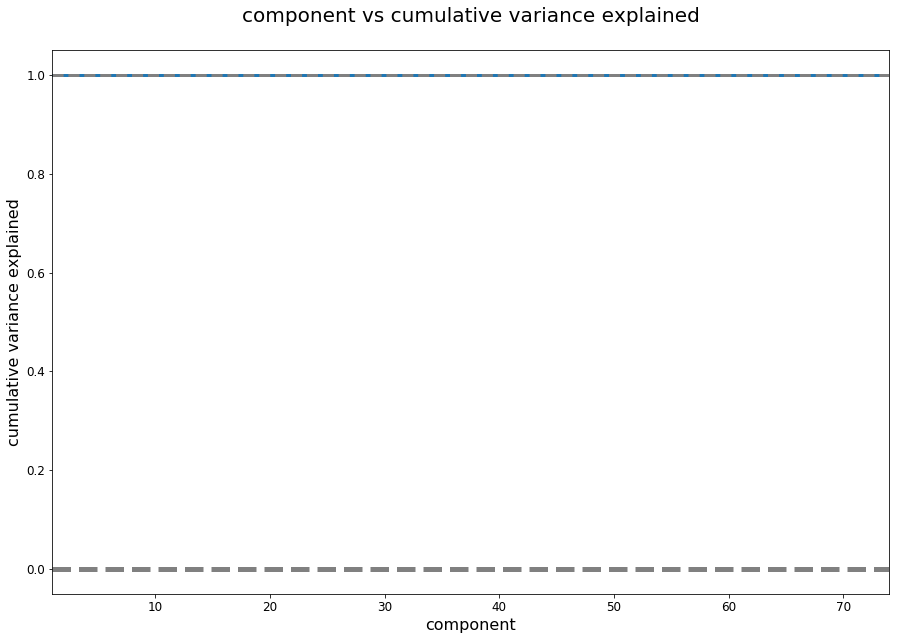

In [163]:
plt.figure(figsize=(15,10))

# HERE IS THE BASIC PLOT

# Plot the cumulative explained variance
component_number = list(range(1, 75))
plt.plot(component_number, cum_var_exp_nosin, lw=3)

# NOW MAKE IT LOOK PRETTY

# Add horizontal lines at y=0 and y=100
plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=3, color='grey', ls='dashed')

# Set the x and y axis limits
ax = plt.gca()
ax.set_xlim([1,74])
ax.set_ylim([-0.05,1.05])

# Label the axes
ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)

# Make the tick labels bigger
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
# Add title
ax.set_title('component vs cumulative variance explained\n', fontsize=20)

plt.show()

In [164]:
print(cum_var_exp_nosin)

[0.99999965 0.99999974 0.99999978 0.99999979 0.9999998  0.99999982
 0.99999983 0.99999984 0.99999985 0.99999986 0.99999988 0.99999988
 0.99999989 0.9999999  0.99999991 0.99999992 0.99999992 0.99999993
 0.99999993 0.99999994 0.99999994 0.99999995 0.99999995 0.99999995
 0.99999996 0.99999996 0.99999996 0.99999997 0.99999997 0.99999997
 0.99999997 0.99999997 0.99999998 0.99999998 0.99999998 0.99999998
 0.99999998 0.99999998 0.99999999 0.99999999 0.99999999 0.99999999
 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


Taking out DOY_SIN actually increased the percentage of variation accounted for by the first PCA feature. So I went back to using the full dataframe. At this point, all the categorical data has been one-hot encoded, the PCA transformation has taken care of the collinearity that encoding causes, the numerical data has all been scaled, no correlation coefficients were very strong, and taking out one of the DOY columns basically did nothing. I conclude that something **extremely** improbable has occured, and because I have a good grasp on statistics I know that happens. I am moving on to do a PCA transformation on the entire data set.

In [165]:
pca_wburn = PCA()
pca_wburn.fit(df_wburn.drop(['ARSON'], axis=1))

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

The next few cells are from the PCA lesson.

In [166]:
var_exp_wburn = pca_wburn.explained_variance_ratio_
cum_var_exp_wburn = np.cumsum(var_exp_wburn)

In [167]:
len(pca_wburn.components_)

75

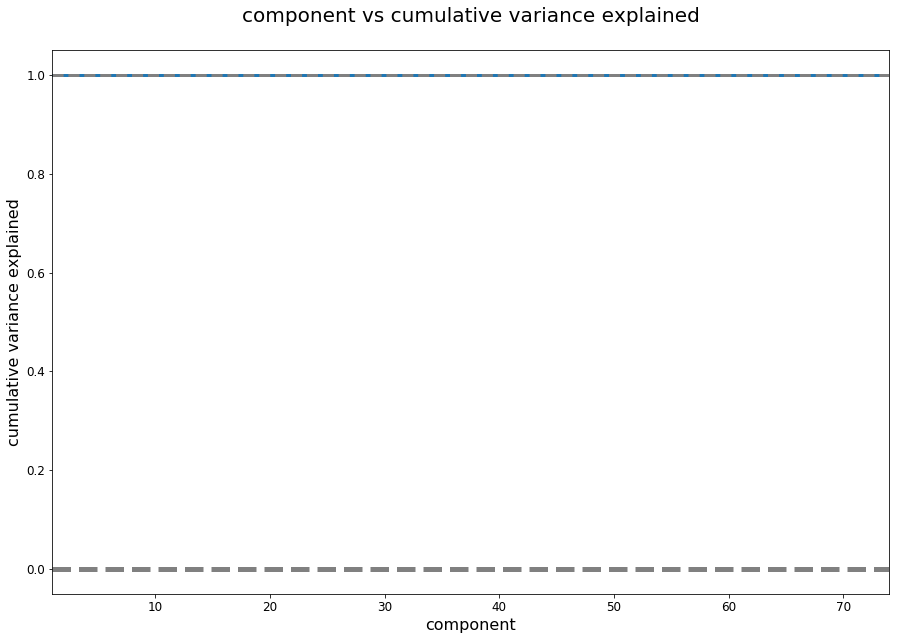

In [168]:
plt.figure(figsize=(15,10))

# HERE IS THE BASIC PLOT

# Plot the cumulative explained variance
component_number = list(range(1, 76))
plt.plot(component_number, cum_var_exp_wburn, lw=3)

# NOW MAKE IT LOOK PRETTY

# Add horizontal lines at y=0 and y=100
plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=3, color='grey', ls='dashed')

# Set the x and y axis limits
ax = plt.gca()
ax.set_xlim([1,74])
ax.set_ylim([-0.05,1.05])

# Label the axes
ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)

# Make the tick labels bigger
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
# Add title
ax.set_title('component vs cumulative variance explained\n', fontsize=20)

plt.show()

I don't trust that result at all. But I have tried a bunch of different ways to catch something going wrong with it. I dropped one of my cyclical DOY columns - nothing. I scaled and normalized both my numeric columns: fire size and burn time - nothing. I checked the corrcoeffs of each feature against Arson: the biggest one is 0.3 - nothing there either. I checked to see what the correlation between BURN_TIME and FIRE_SIZE is, it's 0.1 - nothing. I have looked over the code, which is quite simple and would be hard to screw up in such a way that it would still run, several times and found no errors. I suppose it's possible that something extraordinarily improbable has occurred here.

In [169]:
print(cum_var_exp_wburn)

[0.99999961 0.99999969 0.99999975 0.99999979 0.9999998  0.99999981
 0.99999983 0.99999984 0.99999985 0.99999986 0.99999987 0.99999988
 0.99999989 0.9999999  0.99999991 0.99999991 0.99999992 0.99999993
 0.99999993 0.99999994 0.99999994 0.99999995 0.99999995 0.99999995
 0.99999996 0.99999996 0.99999996 0.99999997 0.99999997 0.99999997
 0.99999997 0.99999997 0.99999998 0.99999998 0.99999998 0.99999998
 0.99999998 0.99999998 0.99999999 0.99999999 0.99999999 0.99999999
 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.        ]


I'll keep 4 of my pca components for now. That keeps 99.999984% of my variance explained while dropping almost all of my variables. This solves the high dimensionality my data had after one-hot encoding. It also is going to make everything run much faster than if I had needed to keep a large number of features. After I've gotten to the point where I'm scoring models I'll try a few other numbers of PCA features to use, all low to keep my dimensionality down.

**UPDATE:** Setled on 6 PCA features after looking at scores for several different numbers of kept features on a logistic regression.

Time to make my training and testing sets. Then I'll transform with PCA and use that.

In [170]:
X = df_wburn.drop(['ARSON'], axis=1)
y = df_wburn['ARSON']

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [172]:
pca_6 = PCA(n_components=6)
pca_6.fit(X_train)
Xt_train = pca_6.transform(X_train)
Xt_test = pca_6.transform(X_test)

About half of the code for these models came from : http://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html#sphx-glr-auto-examples-ensemble-plot-feature-transformation-py

**Logistic regression.**

In [173]:
lr = LogisticRegression()
lr.fit(Xt_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [174]:
lr.score(Xt_test, y_test)

0.8406318005552252

**Number of estimators for Random Trees, Random Forest, and Gradient Boosting Classifier.** 10 is a common choice so I went with that. This will be tuned later.

In [175]:
n_estimator = 50

**Random Forest.**

In [177]:
rf = RandomForestClassifier(max_depth=4, n_estimators=n_estimator)
rf.fit(Xt_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [178]:
rf.score(Xt_test, y_test)

0.8406318005552252

**Gradient Boosting Classifier**

In [179]:
grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd.fit(Xt_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [180]:
grd.score(Xt_test, y_test)

0.8407245199046627

**XGBoost.**

In [181]:
xgb = XGBClassifier()
xgb.fit(Xt_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [182]:
xgb.score(Xt_test, y_test)

/Users/ryanmetz/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8411063054611697

**Gaussian Naive Bayes.** For all binary features a Bernoulli kernel is used, for categorical data, a multinomial. My data is neither so I went with a Gaussian kernel.

In [183]:
gnb = GaussianNB()
gnb.fit(Xt_train, y_train)

GaussianNB(priors=None)

In [184]:
gnb.score(Xt_test, y_test)

0.5861008241113941

**Calibrated Classifier with LinearSVC.** LinearSVC doesn't have a predict_probas method. Calibrated Classifer not only improves it's performance, it has a predict_probas method, so I use it here.

In [214]:
lsvc = LinearSVC(random_state=42)

In [215]:
cal_class_lsvc = CalibratedClassifierCV(lsvc, cv=2, method='sigmoid')
cal_class_lsvc.fit(Xt_train, y_train)

/Users/ryanmetz/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/ryanmetz/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/ryanmetz/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/calibration.py:447: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
/Users/ryanmetz/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/ryanmetz/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/ryanmetz/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/calibration.py:445: RuntimeWarning: ove

CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0),
            cv=2, method='sigmoid')

In [191]:
cal_class_lsvc.score(Xt_test_svc, y_test_svc)

0.8405138854611375

The below cell was run and an ROC curve was generated below. It was terrible so I commented this all out so it wouldn't be re-run if I end up restarting this kernel and going through everything again.

Wow definitely don't use that one. I'm going to comment grd_lm out above.

The code in the next 2 cells also comes from a GA lesson.

In [192]:
def roc2(probas, true, step=0.01, plot=True):
    """
    probas should be a numpy array of predict_probas
    true is a pandas series of true labels
    step is the step size for checking thresholds
    plot is a boolean for whether we want to generate a plot
    """
    
    probas = probas[:,1]  # The output of predict_proba() is an array of the probabilities for every class, but we only want the probabilities for class 1
    true = true.values    # We need to convert the class labels from a Pandas Series to a numpy array. We do this using the .values attribute
    assert(len(probas) == len(true)) # We're making sure that our probabilities vector is the same length as our true class labesl vector
    
    TPRs = [] # Setting up empty list of True Positive Rate
    FPRs = [] # Setting up empty list of False Positive Rate
    
    for i in np.arange(0.0,1.0,step): # np.arange allows us to use step sizes that are decimals
        preds_class = probas > i # Numpy arrays have a feature called 'broadcasting.' Check the documentation: https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html to see what this does.
        TP = 0 
        FP = 0
        TN = 0
        FN = 0
        for index in range(len(preds_class)): # We're comparing each prediction with each true value here

            if preds_class[index] == 1 and true[index] == 1:
                TP += 1
            elif preds_class[index] == 1 and true[index] == 0:
                FP += 1
            elif preds_class[index] == 0 and true[index] == 0:
                TN += 1 
            elif preds_class[index] == 0 and true[index] == 1:
                FN += 1
                
        TPR = TP/(TP + FN) # Calculating TPR and FPR and appending to our lists
        FPR = FP/(FP + TN)
        
        TPRs.append(TPR)
        FPRs.append(FPR)
        
    if plot: # Only generate a plot if plot == True
        
        plt.rcParams['font.size'] = 14
        plt.plot(FPRs, TPRs, color="orange")
        plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.title('Receiver Operating Characteristic')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.show();
        
    return np.array(TPRs), np.array(FPRs) # We'll neet to have our TPRs and FPRs as arrays so we can use broadcasting in the next function.

def sen_spec(probas, true, stat="sensitivity", stat_val=0.5, step=0.01):
    '''
    This is the function that the assignment is asking for. We'll feed in our probas and true vectors as we do with the previous function, as well
    as we are looking at, as well as the value of that stat that we want to find, and the step size for our roc function.
    
    '''
    
    stat = stat.lower() # turn the string into lowercase for ease of comparison
    
    assert(stat in ["sensitivity", "specificity"]) # Throw an error if the user did not write sensitivity or specificity
    
    TPRs, FPRs = roc2(probas, true, step=step, plot=False) # use our roc function to get vectors of TPR and FPR
    
    if stat == "sensitivity":
        diffs = np.absolute(TPRs - stat_val) # We won't necessarily be able to find a threshold that gives the exact value we're looking for, but we can find the one that gets us the closest.
        loc = np.argmin(diffs) # We want to find the index of the TPR that was closest to the value we specified
        threshold = loc * step
        sensitivity = TPRs[loc]
        spec_corr = (1 - FPRs[loc])
        
        print("Sensitivity: {:.5f}%, Specificity: {:.5f}%, Threshold: {}%".format(sensitivity*100, spec_corr*100, threshold*100))
        return TPRs, FPRs
    
    elif stat == "specificity":
        specificities = 1 - FPRs # FPR = 1 - specificity --> specificity = 1 - FPR
        diffs = np.absolute(specificities - stat_val)
        loc = np.argmin(diffs)
        threshold = loc * step
        specificity = specificities[loc]
        sens_corr = (TPRs[loc])
        
        print("Specificity: {:.5f}%, Sensitivity: {:.5f}%, Threshold: {}%".format(specificity*100, sens_corr*100, threshold*100))
        return TPRs, FPRs

In [193]:
def auc(y, x):
    
    auc = 0
    for i in range(1,len(x)):
        auc += ((y[i] + y[i-1])/2)*abs((x[i] - x[i-1]))
        
    return auc

Going to re-run all the models for scoring with the above functions.

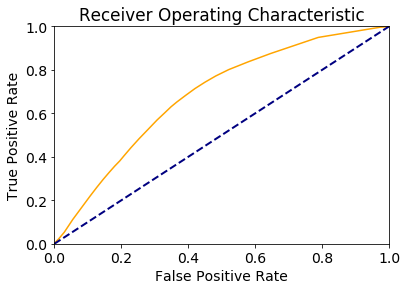

(array([1.        , 0.99958932, 0.9991102 , 0.99873374, 0.99828884,
        0.99780972, 0.99722793, 0.99613279, 0.9491102 , 0.87491444,
        0.83685832, 0.80106092, 0.77197125, 0.74370294, 0.71406571,
        0.68203285, 0.65171116, 0.63035592, 0.60102669, 0.56940452,
        0.52642026, 0.48340178, 0.44209446, 0.40530459, 0.38097194,
        0.35657084, 0.32878166, 0.295859  , 0.25975359, 0.2192334 ,
        0.17039699, 0.11279945, 0.05277207, 0.02251882, 0.00732375,
        0.00198494, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [194]:
roc2(lr.predict_proba(Xt_test), y_test)

A "by-hand gridsearch" shows that 6 PCA features gives the best sensitivity. Could be a local maxima but I'm not willing to make the data array even bigger than 8 given how many rows I have.

In [195]:
TPRs_lr, FPRs_lr = sen_spec(probas=lr.predict_proba(Xt_test), true=y_test, stat="specificity", stat_val = 0.99, step=0.01)


Specificity: 98.70433%, Sensitivity: 2.25188%, Threshold: 33.0%


In [196]:
auc(TPRs_lr, FPRs_lr)

0.6827029148081684

In [197]:
lr_preds = lr.predict(Xt_test)

In [198]:
print(classification_report(y_test, lr_preds))


             precision    recall  f1-score   support

          0       0.84      1.00      0.91    154129
          1       0.00      0.00      0.00     29220

avg / total       0.71      0.84      0.77    183349



/Users/ryanmetz/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Bad bad bad. Gotta balance. No way around it.

Now for the random forest.

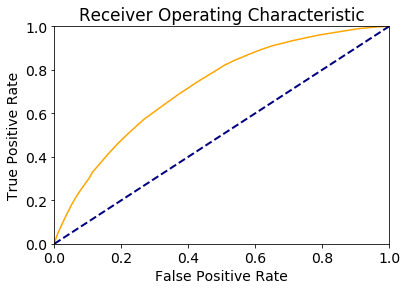

(array([1.        , 1.        , 1.        , 1.        , 0.99794661,
        0.98908282, 0.98059548, 0.95975359, 0.93538672, 0.91047228,
        0.89199179, 0.86971253, 0.84209446, 0.82002053, 0.79787817,
        0.76786448, 0.74575633, 0.725154  , 0.68942505, 0.64284736,
        0.57255305, 0.51067762, 0.46488706, 0.44267625, 0.41433949,
        0.32908966, 0.30160849, 0.28312799, 0.27405886, 0.26238877,
        0.24445585, 0.21646133, 0.1784052 , 0.12275838, 0.0519165 ,
        0.01273101, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [199]:
roc2(rf.predict_proba(Xt_test), y_test)

In [200]:
TPRs_rf, FPRs_rf = sen_spec(probas=rf.predict_proba(Xt_test), true=y_test, stat="specificity", stat_val = 0.99, step=0.01)


Specificity: 98.86199%, Sensitivity: 5.19165%, Threshold: 34.0%


In [201]:
auc(TPRs_rf, FPRs_rf)

0.7209612193434117

Next is Gradient Boosted Trees Classifier

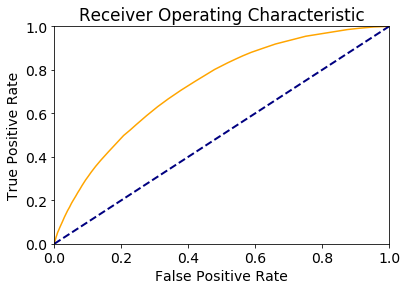

(array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 9.97296372e-01,
        9.91649555e-01, 9.85318275e-01, 9.54449008e-01, 9.40691307e-01,
        9.18925394e-01, 8.98836413e-01, 8.80424367e-01, 8.65023956e-01,
        8.49691992e-01, 8.32375086e-01, 8.01848049e-01, 7.47056810e-01,
        7.06262834e-01, 6.66290212e-01, 6.30424367e-01, 5.89185489e-01,
        5.48049281e-01, 5.23134839e-01, 4.98083504e-01, 4.59993155e-01,
        4.23340178e-01, 3.83983573e-01, 3.56023272e-01, 3.29021218e-01,
        3.10198494e-01, 2.93394935e-01, 2.67761807e-01, 2.50444901e-01,
        2.36310746e-01, 2.17727584e-01, 1.97741273e-01, 1.86105407e-01,
        1.68856947e-01, 1.52600958e-01, 1.22997947e-01, 1.04038330e-01,
        7.47433265e-02, 6.13278576e-02, 5.25325120e-02, 3.71663244e-02,
        3.23066393e-02, 2.38193018e-02, 1.17727584e-02, 8.52156057e-03,
        2.53251198e-03, 1.54004107e-03, 1.30047912e-03, 3.42231348e-05,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [202]:
roc2(grd.predict_proba(Xt_test), y_test)

In [203]:
TPRs_grd, FPRs_grd = sen_spec(probas=grd.predict_proba(Xt_test), true=y_test, stat="specificity", stat_val = 0.99, step=0.01)


Specificity: 99.00343%, Sensitivity: 5.25325%, Threshold: 42.0%


In [204]:
auc(TPRs_grd, FPRs_grd)

0.7274852242161001

Now for XGBoost

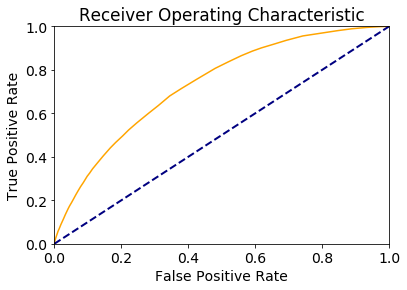

(array([1.00000000e+00, 9.99965777e-01, 9.98459959e-01, 9.95311431e-01,
        9.88843258e-01, 9.80663929e-01, 9.55989049e-01, 9.35557837e-01,
        9.18343600e-01, 9.01060917e-01, 8.86447639e-01, 8.65263518e-01,
        8.52156057e-01, 8.34941821e-01, 8.06913073e-01, 7.55167693e-01,
        7.13347023e-01, 6.79979466e-01, 6.36173854e-01, 6.00171116e-01,
        5.56125941e-01, 5.23305955e-01, 4.96201232e-01, 4.66153320e-01,
        4.41341547e-01, 4.04004107e-01, 3.70225873e-01, 3.44695414e-01,
        3.25667351e-01, 3.10711841e-01, 2.81793292e-01, 2.63141684e-01,
        2.43326489e-01, 2.25735797e-01, 2.06707734e-01, 1.89801506e-01,
        1.74093087e-01, 1.61396304e-01, 1.35215606e-01, 1.14955510e-01,
        8.81587953e-02, 6.91649555e-02, 5.72895277e-02, 4.94182067e-02,
        3.93223819e-02, 3.34360027e-02, 2.55646817e-02, 2.25530459e-02,
        1.88569473e-02, 1.35865845e-02, 9.61670089e-03, 6.94729637e-03,
        2.87474333e-03, 1.91649555e-03, 1.74537988e-03, 1.026694

In [205]:
roc2(xgb.predict_proba(Xt_test), y_test)

In [206]:
TPRs_xgb, FPRs_xgb = sen_spec(probas=xgb.predict_proba(Xt_test), true=y_test, stat="specificity", stat_val = 0.99, step=0.01)


Specificity: 99.06896%, Sensitivity: 4.94182%, Threshold: 43.0%


In [207]:
auc(TPRs_xgb, FPRs_xgb)

0.7313212454163118

Now Gaussian Naive Bayes Classifier.

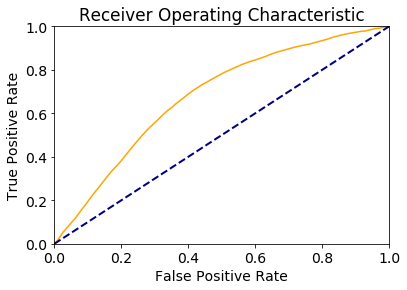

(array([9.99828884e-01, 9.93976728e-01, 9.93531828e-01, 9.93052704e-01,
        9.92778919e-01, 9.92334018e-01, 9.92026010e-01, 9.91649555e-01,
        9.91478439e-01, 9.91375770e-01, 9.91238877e-01, 9.91101985e-01,
        9.90896646e-01, 9.90520192e-01, 9.89733060e-01, 9.88535250e-01,
        9.85660507e-01, 9.82819986e-01, 9.80698152e-01, 9.78918549e-01,
        9.78336756e-01, 9.77857632e-01, 9.77070500e-01, 9.73682409e-01,
        9.70568104e-01, 9.65674196e-01, 9.57665982e-01, 9.48939083e-01,
        9.40999316e-01, 9.34223135e-01, 9.26762491e-01, 9.18959617e-01,
        9.11943874e-01, 9.02566735e-01, 8.91923340e-01, 8.81553730e-01,
        8.70499658e-01, 8.61841205e-01, 8.54996578e-01, 8.46611910e-01,
        8.36755647e-01, 8.24537988e-01, 8.12046543e-01, 7.99520876e-01,
        7.88706366e-01, 7.77310062e-01, 7.67008898e-01, 7.57563313e-01,
        7.49144422e-01, 7.40793977e-01, 7.31998631e-01, 7.19507187e-01,
        7.06981520e-01, 6.91854894e-01, 6.74024641e-01, 6.583846

In [208]:
roc2(gnb.predict_proba(Xt_test), y_test)

In [209]:
TPRs_gnb, FPRs_gnb = sen_spec(probas=gnb.predict_proba(Xt_test), true=y_test, stat="specificity", stat_val = 0.99, step=0.01)


Specificity: 99.11308%, Sensitivity: 1.43053%, Threshold: 77.0%


In [210]:
auc(TPRs_gnb, FPRs_gnb)

0.6765104039915293

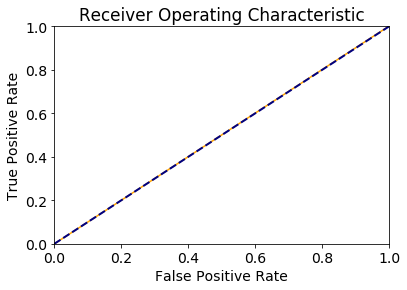

(array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        9.99965777e-01, 9.99931554e-01, 9.99897331e-01, 9.99897331e-01,
        9.99897331e-01, 9.99897331e-01, 9.99897331e-01, 9.99828884e-01,
        9.99828884e-01, 9.99760438e-01, 9.99589322e-01, 9.99418207e-01,
        1.02669405e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [216]:
roc2(cal_class_lsvc.predict_proba(Xt_test), y_test)

I screwed up by calibrating and training on the same data set, which is fatal to this technique. I'll have to go fix that.

In [217]:
TPRs_calclass_lsvc, FPRs_calclass_lsvc = sen_spec(probas=cal_class_lsvc.predict_proba(Xt_test), true=y_test, stat="specificity", stat_val = 0.99, step=0.01)


Specificity: 99.98118%, Sensitivity: 0.01027%, Threshold: 16.0%


In [218]:
auc(TPRs_calclass_lsvc, FPRs_calclass_lsvc)

0.5007659304064207

It would appear that having my classes unbalanced - cases of Arson make up only 16% of the instances in my sample - has truly come back to haunt me. I will now deal with that in various ways.

In [219]:
df_wburn.ARSON.value_counts()

0    770565
1    146176
Name: ARSON, dtype: int64

In [220]:
# Method 1: downsample majority class

df_minority = df_wburn[df_wburn['ARSON']==1]
df_majority = df_wburn[df_wburn['ARSON']==0]
 
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=146252,     # to match minority class
                                 random_state=42) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.ARSON.value_counts()

0    146252
1    146176
Name: ARSON, dtype: int64

In [221]:
df_downsampled.to_csv('./df_down.csv', index=False)

In [222]:
df_downsampled.shape

(292428, 76)

In [223]:
Xd = df_downsampled.drop(['ARSON'], axis=1)
yd = df_downsampled['ARSON']

In [224]:
Xd_train, Xd_test, y_train_down, y_test_down = train_test_split(Xd, yd, test_size=0.2, random_state=42)

In [225]:
pca_6_down = PCA(n_components=6)
pca_6_down.fit(Xd_train)
Xt_train_down = pca_6_down.transform(Xd_train)
Xt_test_down = pca_6_down.transform(Xd_test)

Initially I tested on down-sampled data. This is wrong. I need to train on my downsampled data and then test against the full data set. Rather and doubling the number of cells below this I went back and re-did it the proper way.

In [226]:
lr_down = LogisticRegression()
lr_down.fit(Xt_train_down, y_train_down)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [227]:
lr_down.score(Xt_test, y_test)

0.6029975620265178

In [228]:
rf_down = RandomForestClassifier(max_depth=4, n_estimators=n_estimator)
rf_down.fit(Xt_train_down, y_train_down)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [229]:
grd_down = GradientBoostingClassifier(n_estimators=n_estimator)
grd_down.fit(Xt_train_down, y_train_down)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [230]:
xgb_down = XGBClassifier()
xgb_down.fit(Xt_train_down, y_train_down)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [231]:
gnb_down = GaussianNB()
gnb_down.fit(Xt_train_down, y_train_down)

GaussianNB(priors=None)

In [232]:
cal_class_lsvc_down = CalibratedClassifierCV(lsvc, cv=2, method='sigmoid')
cal_class_lsvc_down.fit(Xt_train_down, y_train_down)

/Users/ryanmetz/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/ryanmetz/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/ryanmetz/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/calibration.py:447: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
/Users/ryanmetz/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/ryanmetz/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/ryanmetz/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/calibration.py:445: RuntimeWarning: ove

CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0),
            cv=2, method='sigmoid')

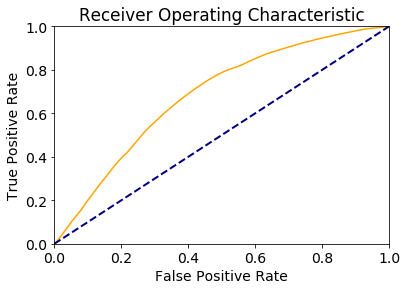

(array([1.00000000e+00, 9.99144422e-01, 9.98836413e-01, 9.98836413e-01,
        9.98699521e-01, 9.98528405e-01, 9.98459959e-01, 9.98288843e-01,
        9.98254620e-01, 9.98186174e-01, 9.98049281e-01, 9.97912389e-01,
        9.97878166e-01, 9.97809719e-01, 9.97741273e-01, 9.97570157e-01,
        9.97501711e-01, 9.97399042e-01, 9.97159480e-01, 9.97091034e-01,
        9.96885695e-01, 9.96817248e-01, 9.96714579e-01, 9.96509240e-01,
        9.96372348e-01, 9.96098563e-01, 9.95756331e-01, 9.95345654e-01,
        9.95037645e-01, 9.94798084e-01, 9.94387406e-01, 9.94010951e-01,
        9.93258042e-01, 9.92026010e-01, 9.86242300e-01, 9.66529774e-01,
        9.43326489e-01, 9.22039699e-01, 8.96851472e-01, 8.73648186e-01,
        8.50821355e-01, 8.34154689e-01, 8.22073922e-01, 8.14544832e-01,
        8.06468172e-01, 7.94147844e-01, 7.79363450e-01, 7.62354552e-01,
        7.45482546e-01, 7.27173169e-01, 7.09650924e-01, 6.92368241e-01,
        6.76488706e-01, 6.65571526e-01, 6.55236140e-01, 6.388774

In [233]:
roc2(lr_down.predict_proba(Xt_test), y_test)

In [234]:
TPRs_lr_down, FPRs_lr_down = sen_spec(probas=lr_down.predict_proba(Xt_test), true=y_test, stat="specificity", stat_val = 0.99, step=0.01)


Specificity: 99.07740%, Sensitivity: 1.42368%, Threshold: 75.0%


In [235]:
auc(TPRs_lr_down, FPRs_lr_down)

0.6823913076243956

In [236]:
lr_down_preds = lr_down.predict(Xt_test)

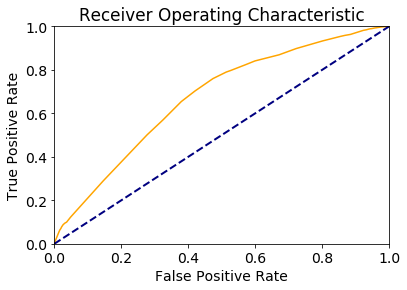

(array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.99962355,
        0.9995551 , 0.99900753, 0.99839151, 0.99818617, 0.99801506,
        0.99739904, 0.99664613, 0.9954141 , 0.99462697, 0.9936345 ,
        0.99240246, 0.99147844, 0.99048597, 0.98956194, 0.98884326,
        0.98750856, 0.9844627 , 0.98169062, 0.96293634, 0.95848734,
        0.95362765, 0.93323066, 0.89801506, 0.86926762, 0.84103354,
        0.82498289, 0.79685147, 0.78983573, 0.75982204, 0.73333333,
        0.7028063 , 0.654141  , 0.56909651, 0.5008898 , 0.28942505,
        0.12330595, 0.09972621, 0.09849418, 0.09787817, 0.09729637,
        0.0967488 , 0.09606434, 0.09383984, 0.09137577, 0.08839836,
        0.08169062, 0.0779603 , 0.0711499 , 0.06303901, 0.05557837,
        0.02737851, 0.01666667, 0.        , 0.  

In [237]:
roc2(rf_down.predict_proba(Xt_test), y_test)

In [238]:
TPRs_rf_down, FPRs_rf_down = sen_spec(probas=rf_down.predict_proba(Xt_test), true=y_test, stat="sensitivity", stat_val = 0.99, step=0.01)


Sensitivity: 98.95619%, Specificity: 5.22549%, Threshold: 33.0%


In [239]:
auc(TPRs_rf_down, FPRs_rf_down)

0.6737902526284139

In [240]:
rf_down_preds = rf_down.predict(Xt_test)

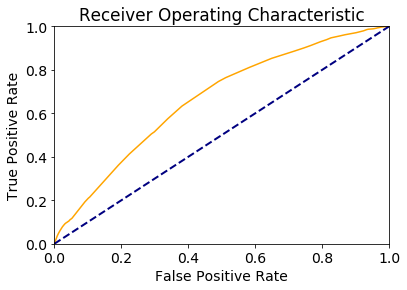

(array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        0.99969199, 0.99941821, 0.99924709, 0.99887064, 0.99811773,
        0.99688569, 0.99531143, 0.99401095, 0.99298426, 0.99147844,
        0.99052019, 0.98973306, 0.98911704, 0.98822724, 0.98754278,
        0.98699521, 0.98631075, 0.98569473, 0.9844627 , 0.97946612,
        0.97094456, 0.96143053, 0.95568104, 0.94722793, 0.93911704,
        0.92915811, 0.91160164, 0.90106092, 0.88545517, 0.85284052,
        0.81054073, 0.76413415, 0.74633812, 0.63329911, 0.57505133,
        0.51495551, 0.50523614, 0.41314168, 0.36146475, 0.21461328,
        0.21030116, 0.19284736, 0.11806982, 0.11492129, 0.11358658,
        0.1118412 , 0.10349076, 0.10225873, 0.10051335, 0.09965777,
        0.09859685, 0.09688569, 0.0940794 , 0.09199179, 0.08915127,
        0.08644764, 0.08227242, 0.07888433, 0.07

In [241]:
roc2(grd_down.predict_proba(Xt_test), y_test)

In [242]:
TPRs_grd_down, FPRs_grd_down = sen_spec(probas=grd_down.predict_proba(Xt_test), true=y_test, stat="specificity", stat_val = 0.99, step=0.01)


Specificity: 98.90741%, Sensitivity: 4.32238%, Threshold: 78.0%


In [243]:
auc(TPRs_grd_down, FPRs_grd_down)

0.6635894641958118

In [244]:
grd_down_preds = grd_down.predict(Xt_test)

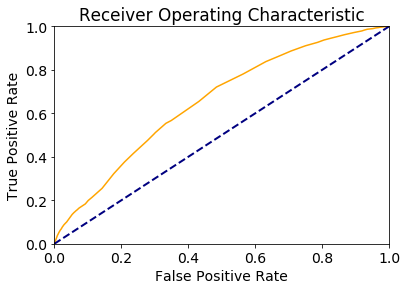

(array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 9.99965777e-01,
        9.99965777e-01, 9.99931554e-01, 9.99931554e-01, 9.99863107e-01,
        9.99623546e-01, 9.98973306e-01, 9.98254620e-01, 9.97535934e-01,
        9.96783025e-01, 9.96167009e-01, 9.95311431e-01, 9.94421629e-01,
        9.93668720e-01, 9.92813142e-01, 9.91991786e-01, 9.91409993e-01,
        9.91067762e-01, 9.90451745e-01, 9.89596167e-01, 9.88877481e-01,
        9.88569473e-01, 9.88056126e-01, 9.87542779e-01, 9.87132101e-01,
        9.86652977e-01, 9.85352498e-01, 9.83367556e-01, 9.78986995e-01,
        9.71594798e-01, 9.61533196e-01, 9.52874743e-01, 9.45756331e-01,
        9.37200548e-01, 9.26454483e-01, 9.10780287e-01, 8.86687201e-01,
        8.65708419e-01, 8.37885010e-01, 7.80971937e-01, 7.20944559e-01,
        6.54722793e-01, 5.67043121e-01, 5.54140999e-01, 5.11875428e-01,
        5.03490760e-01, 4.75188227e-01, 4.15811088e-01, 3.760438

In [245]:
roc2(xgb_down.predict_proba(Xt_test), y_test)

In [246]:
TPRs_xgb_down, FPRs_xgb_down = sen_spec(probas=xgb_down.predict_proba(Xt_test), true=y_test, stat="sensitivity", stat_val = 0.99, step=0.01)


Sensitivity: 98.95962%, Specificity: 4.87124%, Threshold: 26.0%


In [247]:
auc(TPRs_xgb_down, FPRs_xgb_down)

0.6546048844503967

In [248]:
xgb_down_preds = xgb_down.predict(Xt_test)

/Users/ryanmetz/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


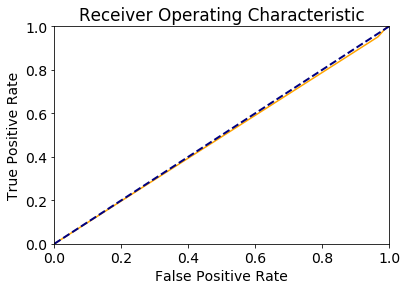

(array([1.        , 1.        , 0.99996578, 0.99996578, 0.99993155,
        0.99993155, 0.99989733, 0.99989733, 0.99989733, 0.99989733,
        0.99989733, 0.99989733, 0.99989733, 0.99989733, 0.99989733,
        0.99989733, 0.99989733, 0.99989733, 0.99989733, 0.99989733,
        0.99989733, 0.99989733, 0.99986311, 0.99982888, 0.99982888,
        0.99982888, 0.99982888, 0.99982888, 0.99982888, 0.99982888,
        0.99982888, 0.99982888, 0.99979466, 0.99976044, 0.99976044,
        0.99976044, 0.99972621, 0.99969199, 0.99958932, 0.99958932,
        0.9995551 , 0.9995551 , 0.99952088, 0.99948665, 0.99941821,
        0.99928131, 0.99924709, 0.99897331, 0.99883641, 0.99770705,
        0.95167693, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [249]:
roc2(cal_class_lsvc_down.predict_proba(Xt_test), y_test)

In [250]:
TPRs_cal_class_lsvc_down, FPRs_cal_class_lsvc_down = sen_spec(probas=cal_class_lsvc_down.predict_proba(Xt_test), true=y_test, stat="sensitivity", stat_val = 0.99, step=0.01)


Sensitivity: 99.77070%, Specificity: 0.65984%, Threshold: 49.0%


In [251]:
auc(TPRs_cal_class_lsvc_down, FPRs_cal_class_lsvc_down)

0.4926996014285641

In [252]:
cal_class_lsvc_down_preds = cal_class_lsvc_down.predict(Xt_test)

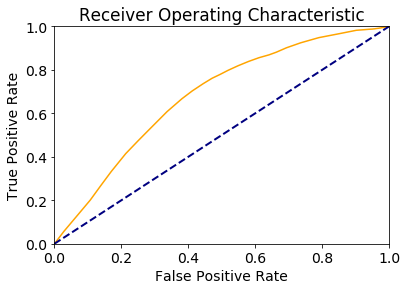

(array([9.99828884e-01, 9.94969199e-01, 9.94866530e-01, 9.94695414e-01,
        9.94695414e-01, 9.94626968e-01, 9.94558522e-01, 9.94421629e-01,
        9.94284736e-01, 9.94216290e-01, 9.94113621e-01, 9.94045175e-01,
        9.93976728e-01, 9.93942505e-01, 9.93874059e-01, 9.93702943e-01,
        9.93634497e-01, 9.93531828e-01, 9.93531828e-01, 9.93429158e-01,
        9.93360712e-01, 9.93292266e-01, 9.93292266e-01, 9.93223819e-01,
        9.93155373e-01, 9.93018480e-01, 9.92915811e-01, 9.92847365e-01,
        9.92676249e-01, 9.92642026e-01, 9.92642026e-01, 9.92470910e-01,
        9.92368241e-01, 9.92299795e-01, 9.92265572e-01, 9.92197125e-01,
        9.92197125e-01, 9.92162902e-01, 9.92094456e-01, 9.92026010e-01,
        9.91957563e-01, 9.91820671e-01, 9.91683778e-01, 9.91478439e-01,
        9.91375770e-01, 9.91273101e-01, 9.91238877e-01, 9.91136208e-01,
        9.91067762e-01, 9.90999316e-01, 9.90896646e-01, 9.90725530e-01,
        9.90657084e-01, 9.90520192e-01, 9.90314853e-01, 9.902464

In [253]:
roc2(gnb_down.predict_proba(Xt_test), y_test)

In [254]:
TPRs_gnb_down, FPRs_gnb_down = sen_spec(probas=gnb_down.predict_proba(Xt_test), true=y_test, stat="sensitivity", stat_val = 0.99, step=0.01)


Sensitivity: 99.00068%, Specificity: 3.75011%, Threshold: 56.00000000000001%


In [255]:
auc(TPRs_gnb_down, FPRs_gnb_down)


0.6796185655775894

In [256]:
gnb_down_preds = gnb_down.predict(Xt_test)

In [257]:
print(classification_report(y_test, lr_down_preds))
print(classification_report(y_test, rf_down_preds))
print(classification_report(y_test, grd_down_preds))
print(classification_report(y_test, xgb_down_preds))
print(classification_report(y_test, cal_class_lsvc_down_preds))
print(classification_report(y_test, gnb_down_preds))


             precision    recall  f1-score   support

          0       0.91      0.58      0.71    154129
          1       0.24      0.71      0.36     29220

avg / total       0.81      0.60      0.66    183349

             precision    recall  f1-score   support

          0       0.91      0.58      0.71    154129
          1       0.24      0.70      0.36     29220

avg / total       0.80      0.60      0.65    183349

             precision    recall  f1-score   support

          0       0.88      0.70      0.78    154129
          1       0.25      0.51      0.33     29220

avg / total       0.78      0.67      0.71    183349

             precision    recall  f1-score   support

          0       0.89      0.67      0.76    154129
          1       0.24      0.55      0.33     29220

avg / total       0.78      0.65      0.69    183349

             precision    recall  f1-score   support

          0       0.79      0.03      0.06    154129
          1       0.16      0.95 

**Class Balance Method 2:** up-sampling the minority class.

In [199]:
df_wburn.ARSON.value_counts()

0    771131
1    146252
Name: ARSON, dtype: int64

In [200]:
df_majority_up = df_wburn[df_wburn.ARSON==0]
df_minority_up = df_wburn[df_wburn.ARSON==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority_up, 
                                 replace=True,     # sample with replacement
                                 n_samples=771131,    # to match majority class
                                 random_state=42) # reproducible results
 
# Combine majority class with upsampled minority class
df_up = pd.concat([df_majority_up, df_minority_upsampled])
 
# Display new class counts
df_up.ARSON.value_counts()

1    771131
0    771131
Name: ARSON, dtype: int64

In [201]:
Xu = df_up.drop(['ARSON'], axis=1)
yu = df_up['ARSON']

In [202]:
X_train_u, X_test_u, yu_train, yu_test = train_test_split(Xu, yu, test_size=0.2, random_state=42)

In [203]:
pca_6_up = PCA(n_components=6)
pca_6_up.fit(X_train_u)
Xu_train = pca_6_up.transform(X_train_u)
Xu_test = pca_6_up.transform(X_test_u)

In [204]:
lr_up = LogisticRegression()
lr_up.fit(Xu_train, yu_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [205]:
rf_up = RandomForestClassifier(max_depth=4, n_estimators=n_estimator)
rf_up.fit(Xu_train, yu_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [206]:
grd_up = GradientBoostingClassifier(n_estimators=n_estimator)
grd_up.fit(Xu_train, yu_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [207]:
xgb_up = XGBClassifier()
xgb_up.fit(Xu_train, yu_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [208]:
gnb_up = GaussianNB()
gnb_up.fit(Xu_train, yu_train)

GaussianNB(priors=None)

In [209]:
cal_class_lsvc_up = CalibratedClassifierCV(lsvc, cv=2, method='sigmoid')
cal_class_lsvc_up.fit(Xu_train, yu_train)

/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/calibration.py:447: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/calibration.py:445: R

CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0),
            cv=2, method='sigmoid')

Train on the upsampled class, test on the full data set.

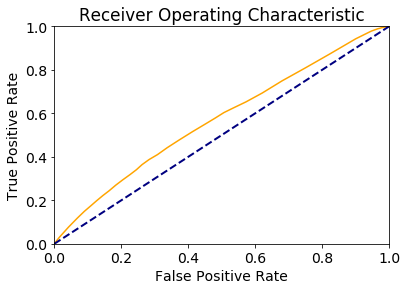

Specificity: 99.51268%, Sensitivity: 1.03855%, Threshold: 69.0%


In [210]:
roc2(lr_up.predict_proba(Xt_test), y_test)

TPRs_lr_up, FPRs_lr_up = sen_spec(probas=lr_up.predict_proba(Xt_test), true=y_test, stat="specificity", stat_val = 0.99, step=0.01)

auc(TPRs_lr_up, FPRs_lr_up)

lr_up_preds = lr_up.predict(Xt_test)

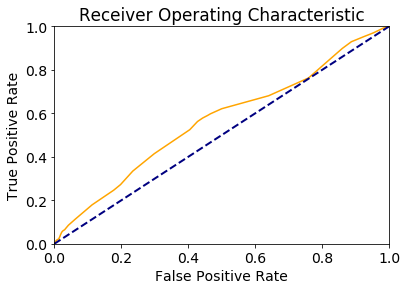

Sensitivity: 99.18959%, Specificity: 1.75785%, Threshold: 32.0%


In [211]:
roc2(rf_up.predict_proba(Xt_test), y_test)

TPRs_rf_up, FPRs_rf_up = sen_spec(probas=rf_up.predict_proba(Xt_test), true=y_test, stat="sensitivity", stat_val = 0.99, step=0.01)

auc(TPRs_rf_up, FPRs_rf_up)

rf_up_preds = rf_up.predict(Xt_test)

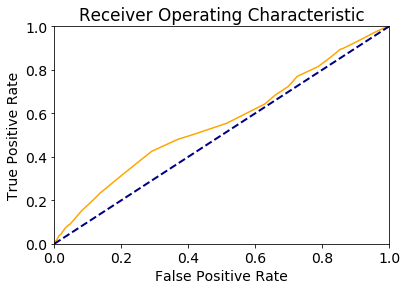

Specificity: 99.01174%, Sensitivity: 2.56742%, Threshold: 71.0%


In [212]:
roc2(grd_up.predict_proba(Xt_test), y_test)

TPRs_grd_up, FPRs_grd_up = sen_spec(probas=grd_up.predict_proba(Xt_test), true=y_test, stat="specificity", stat_val = 0.99, step=0.01)

auc(TPRs_grd_up, FPRs_grd_up)

grd_up_preds = grd_up.predict(Xt_test)

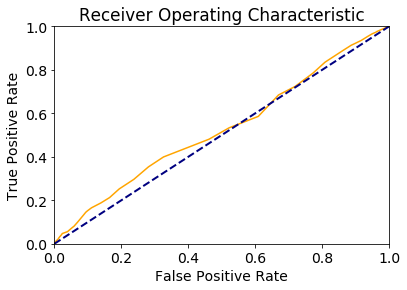

Sensitivity: 99.15214%, Specificity: 1.36137%, Threshold: 28.000000000000004%


/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [213]:
roc2(xgb_up.predict_proba(Xt_test), y_test)

TPRs_xgb_up, FPRs_xgb_up = sen_spec(probas=xgb_up.predict_proba(Xt_test), true=y_test, stat="sensitivity", stat_val = 0.99, step=0.01)

auc(TPRs_xgb_up, FPRs_xgb_up)

xgb_up_preds = xgb_up.predict(Xt_test)

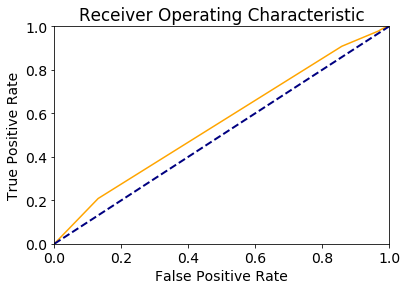

Sensitivity: 98.97507%, Specificity: 1.88957%, Threshold: 47.0%


In [214]:
roc2(cal_class_lsvc_up.predict_proba(Xt_test), y_test)

TPRs_cal_class_lsvc_up, FPRs_cal_class_lsvc_up = sen_spec(probas=cal_class_lsvc_up.predict_proba(Xt_test), true=y_test, stat="sensitivity", stat_val = 0.99, step=0.01)

auc(TPRs_cal_class_lsvc_up, FPRs_cal_class_lsvc_up)

cal_class_lsvc_up_preds = cal_class_lsvc_up.predict(Xt_test)

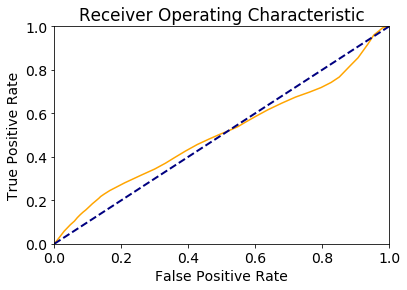

Sensitivity: 99.14192%, Specificity: 2.09657%, Threshold: 48.0%


In [215]:
roc2(gnb_up.predict_proba(Xt_test), y_test)

TPRs_gnb_up, FPRs_gnb_up = sen_spec(probas=gnb_up.predict_proba(Xt_test), true=y_test, stat="sensitivity", stat_val = 0.99, step=0.01)

auc(TPRs_gnb_up, FPRs_gnb_up)

gnb_up_preds = gnb_up.predict(Xt_test)

In [216]:
print(classification_report(y_test, lr_up_preds))
print(classification_report(y_test, rf_up_preds))
print(classification_report(y_test, grd_up_preds))
print(classification_report(y_test, xgb_up_preds))
print(classification_report(y_test, cal_class_lsvc_up_preds))
print(classification_report(y_test, gnb_up_preds))

             precision    recall  f1-score   support

          0       0.87      0.55      0.67    154109
          1       0.19      0.55      0.28     29368

avg / total       0.76      0.55      0.61    183477

             precision    recall  f1-score   support

          0       0.85      0.80      0.83    154109
          1       0.21      0.27      0.24     29368

avg / total       0.75      0.72      0.73    183477

             precision    recall  f1-score   support

          0       0.85      0.91      0.88    154109
          1       0.26      0.17      0.20     29368

avg / total       0.76      0.79      0.77    183477

             precision    recall  f1-score   support

          0       0.85      0.76      0.80    154109
          1       0.19      0.30      0.23     29368

avg / total       0.75      0.69      0.71    183477

             precision    recall  f1-score   support

          0       0.89      0.14      0.24    154109
          1       0.17      0.91 

I got better scores with the downsampled data. This is nice because I'm not creating any new data, robust though that method may be, and it will run faster on the smaller set.

The below cells are my ensemble of the above models.

In [258]:
df_downsampled = pd.read_csv('./df_down.csv')

In [259]:
Xd = df_downsampled.drop(['ARSON'], axis=1)
yd = df_downsampled['ARSON']

Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xd, yd, test_size=0.8, random_state=42)

X_small_train, X_small_test, ysmall_train, ysmall_test = train_test_split(Xs_train, ys_train, test_size=0.5, random_state=42)


pca_3_down = PCA(n_components=3)
pca_3_down.fit(X_small_train)
Xsmall_train = pca_3_down.transform(X_small_train)
Xsmall_test = pca_3_down.transform(X_small_test)

In [260]:
n_estimator_ens = 50

In [261]:
lr_ens = LogisticRegression(fit_intercept=False)

rf_ens = RandomForestClassifier(max_depth=3, n_estimators=n_estimator_ens)

grd_ens = GradientBoostingClassifier(n_estimators=n_estimator_ens)

xgb_ens = XGBClassifier()

gnb_ens = GaussianNB()

lsvc = LinearSVC(random_state=42)
cal_class_lsvc_ens = CalibratedClassifierCV(lsvc, cv=2, method='sigmoid')


In [262]:
models = [
    ['logistic', lr_ens],  #these are all tuples, "models" is the list of them
    ['random forest', rf_ens],
    ['gradient boosting', grd_ens],
    ['XGBoost', xgb_ens],
    ['GaussianNB', gnb_ens],
    ['calibrated LinearSVC', cal_class_lsvc_ens]
]

In [263]:
predictions_train = pd.DataFrame()
for model_tup in models:
    name, model = model_tup
    predictions_train[name + ' _pred'] = cross_val_predict(model, Xsmall_train, ysmall_train)
    model.fit(Xsmall_train, ysmall_train)
predictions_train.head()

/Users/ryanmetz/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ryanmetz/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ryanmetz/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ryanmetz/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/calibratio

,logistic _pred,random forest _pred,gradient boosting _pred,XGBoost _pred,GaussianNB _pred,calibrated LinearSVC _pred
0,1,0,1,1,1,1
1,1,1,1,1,1,1
2,0,1,1,1,0,0
3,1,1,1,1,1,1
4,1,1,1,1,1,1


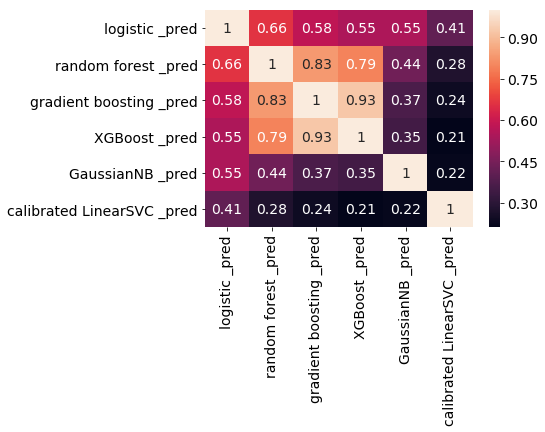

In [264]:
sns.heatmap(predictions_train.corr(), annot=True);

I'm going to use polynomial features for rf and grb.

In [265]:
df_downsampled = pd.read_csv('./df_down.csv')

Xd = df_downsampled.drop(['ARSON'], axis=1)
yd = df_downsampled['ARSON']

X_small_train, X_small_test, ys_train, ys_test = train_test_split(Xd, yd, test_size=0.2, random_state=42)


pca_3_down = PCA(n_components=3)
pca_3_down.fit(X_small_train)
Xs_train = pca_3_down.transform(X_small_train)
Xs_test = pca_3_down.transform(X_small_test)


In [266]:
n_estimator_ens = 50

In [267]:
poly = PolynomialFeatures(degree=2, include_bias=False)

In [268]:

rf_ens = RandomForestClassifier(max_depth=3, n_estimators=n_estimator_ens)
rf_pipe_ens = Pipeline([
    ('poly', poly),
    ('random forest', rf_ens)
])


In [269]:

grd_ens = GradientBoostingClassifier(n_estimators=n_estimator_ens)
grd_pipe_ens = Pipeline([
    ('poly', poly),
    ('gradient boosted', grd_ens)
])

In [270]:
lr = LogisticRegression(fit_intercept=False)

xgb_ens = XGBClassifier()

gnb_ens = GaussianNB()

lsvc = LinearSVC(random_state=42)
cal_class_lsvc_ens = CalibratedClassifierCV(lsvc, cv=2, method='sigmoid')

In [271]:
models_poly = [
    ['logistic', lr], 
    ['random forest poly', rf_pipe_ens],
    ['gradient boosting', grd_pipe_ens],
    ['XGBoost', xgb_ens],
    ['GaussianNB', gnb_ens],
    ['calibrated LinearSVC', cal_class_lsvc_ens]
]

In [272]:
predictions_train_poly = pd.DataFrame()
for model_tup in models_poly:
    name, model = model_tup
    predictions_train_poly[name + ' _pred'] = cross_val_predict(model, Xs_train, ys_train)
    model.fit(Xs_train, ys_train)
predictions_train_poly.head()

/Users/ryanmetz/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ryanmetz/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ryanmetz/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ryanmetz/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/calibratio

,logistic _pred,random forest poly _pred,gradient boosting _pred,XGBoost _pred,GaussianNB _pred,calibrated LinearSVC _pred
0,1,1,1,1,1,1
1,0,1,1,1,1,0
2,1,1,1,1,1,0
3,1,1,1,1,1,1
4,1,1,1,1,1,1


In [273]:
predictions_train_poly.to_csv('./predictions_train_poly.csv', index=False)

In [274]:
predictions_train_poly = pd.read_csv('./predictions_train_poly.csv')

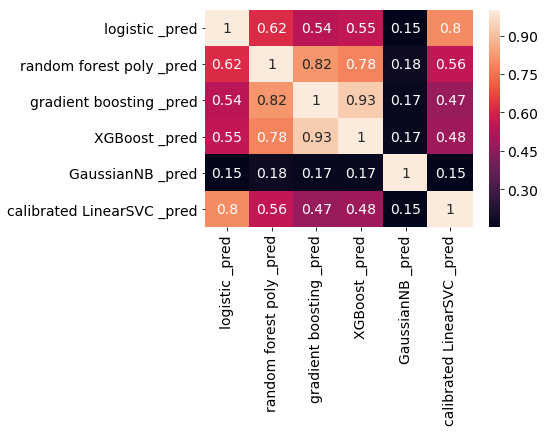

In [275]:
sns.heatmap(predictions_train_poly.corr(), annot=True);

In [276]:
ada_agg = AdaBoostClassifier(n_estimators=75)

In [277]:
ada_agg.fit(predictions_train_poly, ys_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=75, random_state=None)

Since I used only 3 features in the training data for the ensemble I can't use my original Xt_test as it had 6 PCA features. I will have to resplit here from the full data set and PCA encode it with 3 features kept.

In [278]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [279]:
pca_3 = PCA(n_components=3)
pca_3.fit(X2_train)
X_train2 = pca_3_down.transform(X2_train)
X_test2 = pca_3_down.transform(X2_test)

In [280]:
X_test2.shape

(183349, 3)

In [281]:
predictions_test = pd.DataFrame()
for model_tup in models_poly:
    name, model = model_tup
    predictions_test[name + ' _pred'] = model.predict(X_test2)
predictions_test.head(4)

/Users/ryanmetz/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,logistic _pred,random forest poly _pred,gradient boosting _pred,XGBoost _pred,GaussianNB _pred,calibrated LinearSVC _pred
0,0,0,0,0,1,1
1,0,0,0,0,1,0
2,0,1,1,1,1,1
3,0,0,0,0,1,0


In [282]:
predictions_test.to_csv('./predictions_test.csv', index=False)

In [283]:
predictions_test = pd.read_csv('./predictions_test.csv')

In [284]:
predictions_test.shape

(183349, 6)

In [285]:
ada_agg.score(predictions_test, y2_test)

0.6301097906178926

In [286]:
ada_agg_preds = ada_agg.predict(predictions_test)

In [287]:
print(classification_report(y2_test, ada_agg_preds))

             precision    recall  f1-score   support

          0       0.92      0.61      0.74    154129
          1       0.26      0.72      0.38     29220

avg / total       0.81      0.63      0.68    183349



In [288]:
confusion_matrix(y2_test, ada_agg_preds)

array([[94628, 59501],
       [ 8318, 20902]])

In [289]:
print('The number of correct predictions made was: ' + str(92928 + 21270))
print('The number of incorrect predictions made was: ' + str(61181 + 8098))

The number of correct predictions made was: 114198
The number of incorrect predictions made was: 69279


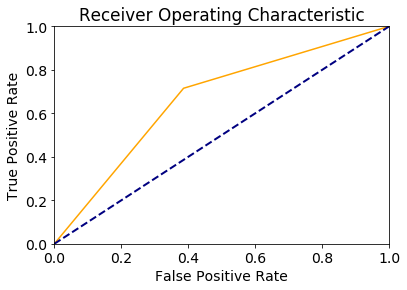

(array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        0.71533196, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [293]:
roc2(ada_agg.predict_proba(predictions_test), y2_test)


There's something wrong with that graph. I try a different function for plotting an ROC curve a few cells down.

In [294]:
TPRs_ada, FPRs_ada = sen_spec(probas=ada_agg.predict_proba(predictions_test), true=y2_test, stat="sensitivity", stat_val = 0.99, step=0.01)


Sensitivity: 100.00000%, Specificity: 0.00000%, Threshold: 0.0%


In [295]:
auc(TPRs_ada, FPRs_ada)

0.6646426056817061

In [297]:
roc_curve(y2_test, ada_agg_preds, pos_label=1, drop_intermediate=True)

(array([0.        , 0.38604675, 1.        ]),
 array([0.        , 0.71533196, 1.        ]),
 array([2, 1, 0]))

0.6862363296363005


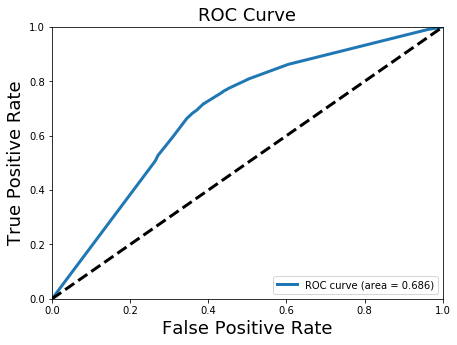

In [302]:
y_hat = ada_agg.predict_proba(predictions_test)[:,1]

print(roc_auc_score(y2_test, y_hat))

model_FPR = dict()
model_TPR = dict()
model_ROC_AUC = dict()

roc_curve(y2_test, y_hat)

model_FPR[1], model_TPR[1], _ = roc_curve(y2_test, y_hat)
model_ROC_AUC[1] = auc(model_FPR[1], model_TPR[1])

plt.figure(figsize=[7,5])
plt.plot(model_FPR[1], model_TPR[1], label='ROC curve (area = %0.3f)' % model_ROC_AUC[1], linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

**The AUC-ROC score is 0.69**

That's not an incredible score, which isn't a huge surprise: the only data used to make the features in the model are the state a fire occurred in, the date the fire was discovered, the date it was contained, and the size of the forest area it burned. However, it's completely un-tuned and there are some other changes I would like to try. I may swap AdaBoost into the ensemble and use XGBoost as the aggregating model, for instance. After model tuning and some changes to the ensemble I should be able to get that score a little higher. Those are next steps.

But why not have some fun and feed this into a neural net?! Just to see what happens.

In [21]:
predictions_train_poly.dtypes

logistic_poly _pred           int64
random forest poly _pred      int64
gradient boosting _pred       int64
XGBoost _pred                 int64
GaussianNB _pred              int64
calibrated LinearSVC _pred    int64
dtype: object

In [22]:
yn_train = ys_train.values.reshape(-1,1)
yn_test = y2_test.values.reshape(-1,1)

In [24]:
predictions.shape

(183477, 1)

Using TensorFlow backend.


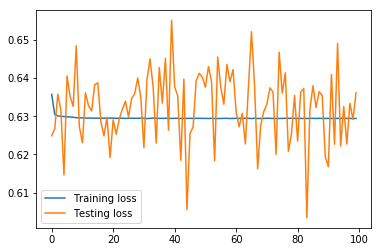

In [23]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
model = Sequential()
n_input = predictions_train_poly.shape[1]
n_hidden = n_input
model.add(Dense(n_hidden, input_dim=n_input, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')
history = model.fit(predictions_train_poly, yn_train, validation_data=(predictions_test, yn_test), 
              epochs=100, batch_size=None, verbose=0)
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.legend()
plt.show()